<a href="https://colab.research.google.com/github/NINAD-ML/PRODIGY_ML_02/blob/main/Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install pandas scikit-learn matplotlib seaborn openpyxl


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization
plt.style.use('seaborn-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.bbox'] = 'tight'

def optimal_clusters(data, max_k=10):
    """Determine optimal number of clusters using Elbow Method"""
    wcss = []
    silhouette_scores = []
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
        kmeans.fit(data)
        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(data, kmeans.labels_))

    # Plot results
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(range(2, max_k+1), wcss, marker='o')
    ax[0].set_title('Elbow Method')
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')

    ax[1].plot(range(2, max_k+1), silhouette_scores, marker='o')
    ax[1].set_title('Silhouette Scores')
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('Score')

    plt.tight_layout()
    return fig

def cluster_analysis(df, features, dataset_name, n_clusters=None):
    """Perform complete clustering analysis"""
    # Data preparation
    df_clean = df[features].dropna().copy()
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df_clean)

    # Determine optimal clusters
    if n_clusters is None:
        elbow_fig = optimal_clusters(scaled_data)
        elbow_fig.savefig(f'{dataset_name}_elbow_analysis.png')
        plt.close(elbow_fig)
        n_clusters = int(input(f"Enter optimal clusters for {dataset_name}: "))

    # Perform clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=20)
    df_clean['Cluster'] = kmeans.fit_predict(scaled_data)

    # Calculate metrics
    silhouette = silhouette_score(scaled_data, df_clean['Cluster'])
    print(f"\n{dataset_name} Silhouette Score: {silhouette:.2f}")

    # PCA Visualization
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(scaled_data)
    df_clean['PCA1'] = pca_results[:, 0]
    df_clean['PCA2'] = pca_results[:, 1]

    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster',
                    data=df_clean, palette='viridis',
                    s=80, alpha=0.8, edgecolor='k')
    plt.title(f'{dataset_name} Customer Clustering')
    plt.savefig(f'{dataset_name}_clusters.png')
    plt.close()

    # Cluster profiles
    profile = df_clean.groupby('Cluster').mean()
    print(f"\n{dataset_name} Cluster Profiles:")
    print(profile)

    return df_clean

# 1. CUSTOMER_DATA.CSV Processing
cust_df = pd.read_csv("customer_data.csv")
cust_result = cluster_analysis(
    cust_df,
    features=['age', 'income', 'purchase_frequency', 'purchase_amount'],
    dataset_name="Customer_Data",
    n_clusters=3
)

# 2. MALL_CUSTOMERS.CSV Processing
mall_df = pd.read_csv("Mall_Customers.csv")
mall_result = cluster_analysis(
    mall_df,
    features=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'],
    dataset_name="Mall_Customers",
    n_clusters=5
)

# 3. ONLINE RETAIL Processing (Enhanced RFM)
def process_online_retail(path):
    """Enhanced RFM analysis for online retail data"""
    df = pd.read_excel(
        path,
        usecols=['CustomerID', 'InvoiceDate', 'Quantity', 'UnitPrice'],
        parse_dates=['InvoiceDate']
    ).dropna(subset=['CustomerID'])

    # RFM Calculation
    snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
    rfm = df.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'InvoiceDate': 'count',
        'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum()
    }).rename(columns={
        'InvoiceDate': 'Recency',
        'count': 'Frequency',
        'UnitPrice': 'Monetary'
    })

    return rfm

online_retail = process_online_retail("Online Retail.xlsx")
online_result = cluster_analysis(
    online_retail,
    features=['Recency', 'Frequency', 'Monetary'],
    dataset_name="Online_Retail",
    n_clusters=4
)

# 4. Summary Report
print("\nFinal Cluster Counts:")
print("Customer Data:\n", cust_result['Cluster'].value_counts())
print("\nMall Customers:\n", mall_result['Cluster'].value_counts())
print("\nOnline Retail:\n", online_result['Cluster'].value_counts())

OSError: 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)

In [ ]:
pip install kagglehub


In [ ]:
import os
import zipfile
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# ----------------------------
# 1. Download Datasets using kagglehub
# ----------------------------
# Download Dunnhumby Complete Journey dataset
dunn_zip_path = kagglehub.dataset_download("frtgnn/dunnhumby-the-complete-journey")
print("Path to Dunnhumby dataset zip:", dunn_zip_path)

# Download Retail Transactions dataset
retail_zip_path = kagglehub.dataset_download("prasad22/retail-transactions-dataset")
print("Path to Retail Transactions dataset zip:", retail_zip_path)

# ----------------------------
# 2. Extract the datasets if they are zip files
# ----------------------------
def extract_zip(zip_path, extract_to_folder):
    if zip_path.endswith('.zip'):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to_folder)
        return extract_to_folder
    return zip_path

dunn_folder = os.path.join(os.path.dirname(dunn_zip_path), "dunnhumby")
retail_folder = os.path.join(os.path.dirname(retail_zip_path), "retail_transactions")

dunn_data_path = extract_zip(dunn_zip_path, dunn_folder)
retail_data_path = extract_zip(retail_zip_path, retail_folder)

# ----------------------------
# 3. Load and Preprocess Each Dataset
# ----------------------------
# --- Process Dunnhumby dataset ---
# (Assuming the extracted folder contains a file named 'transactions.csv'
# with columns: HouseholdKey, BasketID, Date, Spend)
dunn_file = os.path.join(dunn_data_path, "transactions.csv")
df_dunn = pd.read_csv(dunn_file, encoding='latin1')
print("\nDunnhumby dataset head:")
print(df_dunn.head())

# Convert 'Date' to datetime
df_dunn['Date'] = pd.to_datetime(df_dunn['Date'])

# Define snapshot date (1 day after last transaction)
snapshot_date_dunn = df_dunn['Date'].max() + timedelta(days=1)

# Compute RFM metrics for Dunnhumby dataset
rfm_dunn = df_dunn.groupby('HouseholdKey').agg({
    'Date': lambda x: (snapshot_date_dunn - x.max()).days,
    'BasketID': 'nunique',   # Frequency as unique basket count
    'Spend': 'sum'
}).reset_index()

rfm_dunn.rename(columns={'HouseholdKey': 'CustomerID',
                         'Date': 'Recency',
                         'BasketID': 'Frequency',
                         'Spend': 'Monetary'}, inplace=True)

print("\nDunnhumby RFM head:")
print(rfm_dunn.head())

# --- Process Retail Transactions dataset ---
# (Assuming the file 'Retail_Transactions.csv' exists in the extracted folder
# with columns: CustomerID, InvoiceNo, InvoiceDate, Quantity, UnitPrice)
retail_file = os.path.join(retail_data_path, "Retail_Transactions.csv")
df_retail = pd.read_csv(retail_file, encoding='latin1')
print("\nRetail Transactions dataset head:")
print(df_retail.head())

# Convert 'InvoiceDate' to datetime
df_retail['InvoiceDate'] = pd.to_datetime(df_retail['InvoiceDate'])

# Compute TotalAmount as Quantity * UnitPrice
df_retail['TotalAmount'] = df_retail['Quantity'] * df_retail['UnitPrice']

# Define snapshot date for retail dataset
snapshot_date_retail = df_retail['InvoiceDate'].max() + timedelta(days=1)

# Compute RFM metrics for Retail Transactions dataset
rfm_retail = df_retail.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date_retail - x.max()).days,
    'InvoiceNo': 'nunique',  # Frequency as unique invoice count
    'TotalAmount': 'sum'
}).reset_index()

rfm_retail.rename(columns={'InvoiceDate': 'Recency',
                           'InvoiceNo': 'Frequency',
                           'TotalAmount': 'Monetary'}, inplace=True)

print("\nRetail Transactions RFM head:")
print(rfm_retail.head())

# ----------------------------
# 4. Combine RFM Data from Both Datasets
# ----------------------------
# For consistency, ensure both RFM dataframes have the same columns.
rfm_combined = pd.concat([rfm_dunn, rfm_retail], ignore_index=True)
print("\nCombined RFM head:")
print(rfm_combined.head())

# ----------------------------
# 5. Scale Features and Determine Optimal k using Elbow Method
# ----------------------------
features = ['Recency', 'Frequency', 'Monetary']
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_combined[features])

# Elbow plot to decide on number of clusters
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

# ----------------------------
# 6. Apply K-Means Clustering
# ----------------------------
optimal_k = 4  # Choose optimal k from the elbow plot (example: 4)
kmeans = KMeans(n_clusters=optimal_k, init='k-means++', max_iter=300, n_init=10, random_state=42)
rfm_combined['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("\nCluster counts:")
print(rfm_combined['Cluster'].value_counts())

# ----------------------------
# 7. Visualize Clusters using PCA
# ----------------------------
pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm_scaled)
rfm_combined['PC1'] = pca_components[:, 0]
rfm_combined['PC2'] = pca_components[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=rfm_combined, palette='viridis', s=100, alpha=0.8)
plt.title('Combined Customer Segmentation using K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

# ----------------------------
# 8. Display Cluster Summary
# ----------------------------
cluster_summary = rfm_combined.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'NumCustomers'})
print("\nCluster Summary:")
print(cluster_summary)


100%|██████████| 124M/124M [00:02<00:00, 49.8MB/s]

Extracting files...


Path to Dunnhumby dataset zip: /root/.cache/kagglehub/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1


100%|██████████| 35.6M/35.6M [00:00<00:00, 115MB/s] 

Extracting files...


Path to Retail Transactions dataset zip: /root/.cache/kagglehub/datasets/prasad22/retail-transactions-dataset/versions/2


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/frtgnn/dunnhumby-the-complete-journey/versions/1/transactions.csv'

Dataset contents available at: /root/.cache/kagglehub/datasets/shedai/retail-data-set/versions/2


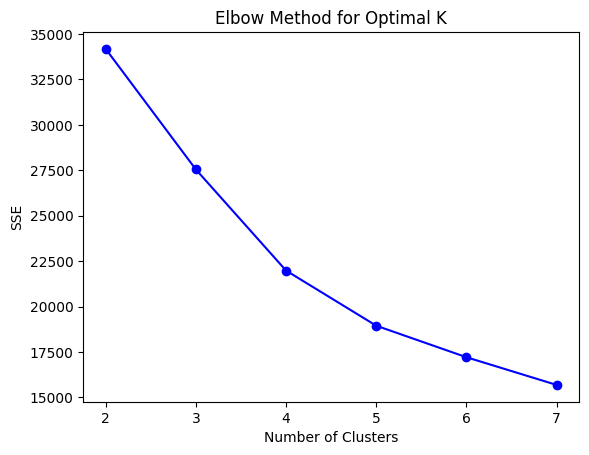

Cluster Characteristics:
          TotalSales                Quantity     ProductID DayOfWeek
                mean       median       mean max      mean      mode
Cluster                                                             
0.0      4507.931716  4325.423729  12.781291  26  2.445647         2
1.0      1663.986946  1245.762712   3.847548  18  1.130708         0
2.0      1698.473188  1273.491525   3.915232  16  1.128179    [3, 4]
3.0      9721.987532  9485.593220   9.945556  26  1.759808         2

Customer Segments:
             Recency   Frequency      Monetary
Cluster                                       
0        1136.040698    4.517442  6.679258e+03
1          37.406250  197.359375  7.339498e+05
2         193.537313   20.287313  5.730134e+04
3           3.333333  558.000000  3.604081e+06


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# Download dataset
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
print(f"Dataset contents available at: {dataset_path}")

# Find CSV file in dataset directory
csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
csv_path = os.path.join(dataset_path, csv_files[0])

# Load data with version-aware column mapping
df = pd.read_csv(csv_path, parse_dates=['Date'])

# Handle version differences
column_map = {
    'DocumentID': 'InvoiceID',
    'SKU': 'ProductID',
    'Price': 'TotalSales',
    'Customer': 'CustomerID'
}

df = df.rename(columns=column_map)

# Data preprocessing
df = df.dropna()
df['UnitPrice'] = df['TotalSales'] / df['Quantity']

# Transaction clustering features
transaction_df = df.groupby('InvoiceID').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum',
    'ProductID': 'nunique',
    'Date': 'first'
}).reset_index()

# Feature engineering
transaction_df['DayOfWeek'] = transaction_df['Date'].dt.dayofweek
transaction_df['TransactionSize'] = np.log1p(transaction_df['TotalSales'])

# Prepare clustering features
features = ['TotalSales', 'Quantity', 'Discount', 'ProductID', 'DayOfWeek']
X = transaction_df[features]

# Handle outliers using IQR
Q1 = X.quantile(0.25)
Q3 = X.quantile(0.75)
IQR = Q3 - Q1
mask = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
X_filtered = X[mask]

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filtered)

# Determine optimal clusters
sse = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.plot(range(2, 8), sse, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal K')
plt.show()

# Apply K-Means clustering
optimal_k = 4  # Update based on elbow curve
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
transaction_df.loc[mask, 'Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze clusters
cluster_analysis = transaction_df.groupby('Cluster').agg({
    'TotalSales': ['mean', 'median'],
    'Quantity': ['mean', 'max'],
    'ProductID': 'mean',
    'DayOfWeek': pd.Series.mode
})

print("Cluster Characteristics:")
print(cluster_analysis)

# Customer segmentation (RFM)
snapshot_date = df['Date'].max() + pd.DateOffset(days=1)
rfm = df.groupby('CustomerID').agg({
    'Date': lambda x: (snapshot_date - x.max()).days,
    'InvoiceID': 'nunique',
    'TotalSales': 'sum'
}).rename(columns={
    'Date': 'Recency',
    'InvoiceID': 'Frequency',
    'TotalSales': 'Monetary'
})

# Cluster customers
rfm_scaled = StandardScaler().fit_transform(rfm)
customer_clusters = KMeans(n_clusters=4, n_init=10, random_state=42).fit_predict(rfm_scaled)
rfm['Cluster'] = customer_clusters

print("\nCustomer Segments:")
print(rfm.groupby('Cluster').mean())

# Save results
transaction_df.to_csv('transaction_clusters.csv', index=False)
rfm.to_csv('customer_segments.csv', index=False)

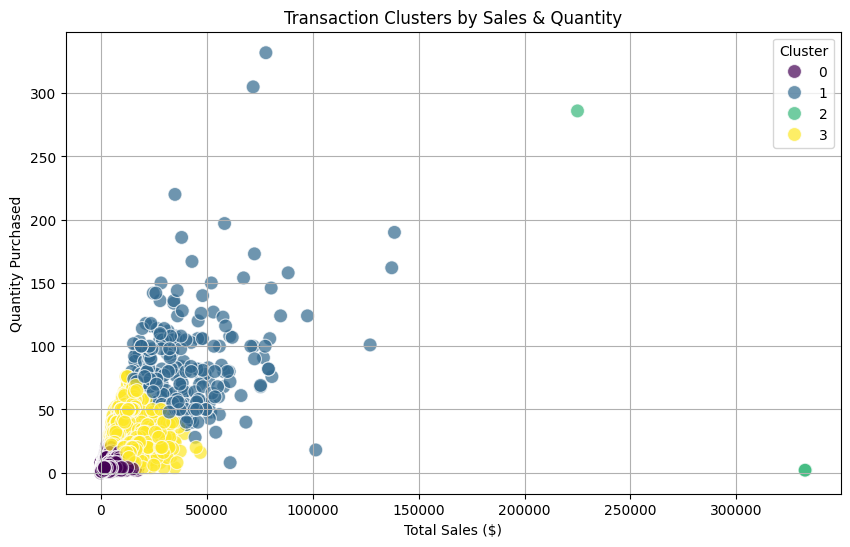

<Figure size 1000x600 with 0 Axes>

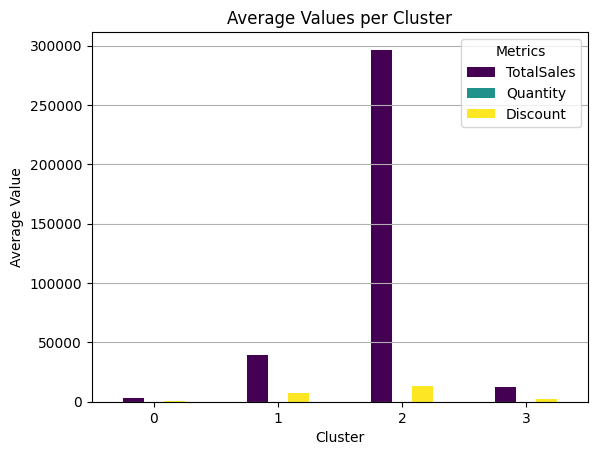

In [ ]:
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Load and prepare data
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(dataset_path, csv_file), parse_dates=['Date'])
df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})

# Transaction clustering
transaction_df = df.groupby('InvoiceID').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Feature scaling
X = transaction_df[['TotalSales', 'Quantity']]  # Focus on 2 main features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# K-Means clustering
kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
transaction_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Visualization 1: Cluster Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=transaction_df,
                x='TotalSales',
                y='Quantity',
                hue='Cluster',
                palette='viridis',
                s=100,
                alpha=0.7)
plt.title('Transaction Clusters by Sales & Quantity')
plt.xlabel('Total Sales ($)')
plt.ylabel('Quantity Purchased')
plt.grid(True)
plt.show()

# Visualization 2: Cluster Characteristics
cluster_means = transaction_df.groupby('Cluster')[['TotalSales', 'Quantity', 'Discount']].mean()

plt.figure(figsize=(10, 6))
cluster_means.plot(kind='bar', colormap='viridis')
plt.title('Average Values per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Value')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.legend(title='Metrics')
plt.show()

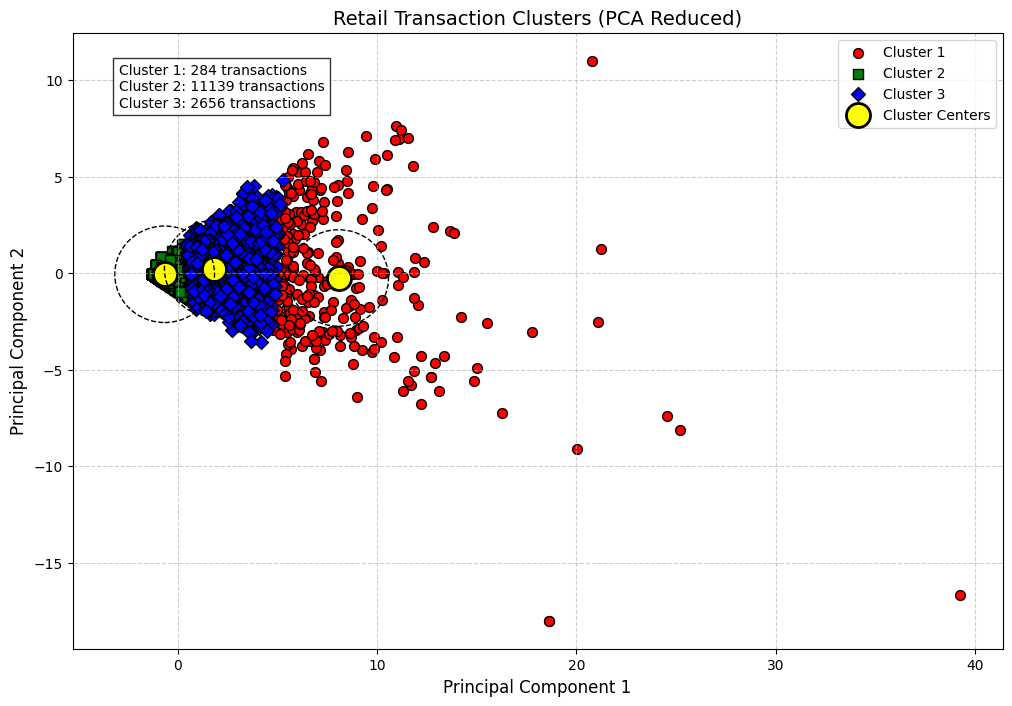

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and preprocess data
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(dataset_path, csv_file), parse_dates=['Date'])

# Standardize column names
df = df.rename(columns={
    'DocumentID': 'InvoiceID',
    'SKU': 'ProductID',
    'Price': 'TotalSales',
    'Customer': 'CustomerID'
})

# Create transaction-level features
transaction_df = df.groupby('InvoiceID').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum',
    'ProductID': 'nunique'
}).reset_index()

# Select and scale features
features = ['TotalSales', 'Quantity', 'Discount', 'ProductID']
X = transaction_df[features]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reduce dimensions for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Apply K-Means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Create visualization
plt.figure(figsize=(12, 8))
colors = ['red', 'green', 'blue']
markers = ['o', 's', 'D']  # Circle, square, diamond

# Plot data points
for i in range(3):
    plt.scatter(X_pca[clusters == i, 0],
                X_pca[clusters == i, 1],
                s=50,
                c=colors[i],
                edgecolor='black',
                marker=markers[i],
                label=f'Cluster {i+1}')

# Plot cluster centers
centers_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centers_pca[:, 0], centers_pca[:, 1],
            s=300, marker='o',
            c='yellow', edgecolor='black',
            linewidth=2, label='Cluster Centers')

# Add circles around clusters
for center in centers_pca:
    circle = plt.Circle(center, 2.5, color='black',
                        fill=False, linestyle='--', linewidth=1)
    plt.gca().add_patch(circle)

# Add labels and legend
plt.title('Retail Transaction Clusters (PCA Reduced)', fontsize=14)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Add cluster statistics
stats_text = "\n".join([f'Cluster {i+1}: {sum(clusters==i)} transactions'
                       for i in range(3)])
plt.text(0.05, 0.95, stats_text,
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

ValueError: X has 3 features, but PCA is expecting 4 features as input.

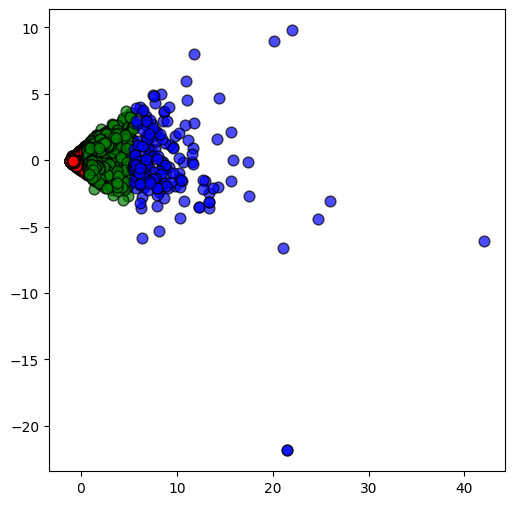

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load and preprocess data
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(dataset_path, csv_file), parse_dates=['Date'])
df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})

# Create three different cluster perspectives
def create_clusters(data, features, n_clusters=3):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data[features])
    pca = PCA(n_components=2)
    return pca.fit_transform(scaled), KMeans(n_clusters=n_clusters, n_init=10).fit(scaled)

# 1. Transaction Value Clusters
trans_features = ['TotalSales', 'Quantity', 'Discount']
trans_pca, trans_kmeans = create_clusters(df.groupby('InvoiceID').agg({
    'TotalSales': 'sum', 'Quantity': 'sum', 'Discount': 'sum'
}).reset_index(), trans_features)

# 2. Customer Behavior Clusters
cust_features = ['TotalSales', 'Quantity', 'Discount']
cust_df = df.groupby('CustomerID').agg({
    'TotalSales': 'mean',
    'Quantity': 'mean',
    'Discount': 'mean'
}).reset_index()
cust_pca, cust_kmeans = create_clusters(cust_df, cust_features)

# 3. Product Popularity Clusters
prod_features = ['TotalSales', 'Quantity', 'Discount']
prod_df = df.groupby('ProductID').agg({
    'TotalSales': 'sum',
    'Quantity': 'count',
    'Discount': 'mean'
}).reset_index()
prod_pca, prod_kmeans = create_clusters(prod_df, prod_features)

# Create visual storytelling
plt.figure(figsize=(20, 6))
colors = ['red', 'green', 'blue']
titles = ['Transaction Patterns', 'Customer Behaviors', 'Product Trends']
datasets = [(trans_pca, trans_kmeans), (cust_pca, cust_kmeans), (prod_pca, prod_kmeans)]

for idx, (pca_data, model) in enumerate(datasets, 1):
    plt.subplot(1, 3, idx)

    # Plot clustered points
    for i in range(3):
        plt.scatter(pca_data[model.labels_ == i, 0],
                    pca_data[model.labels_ == i, 1],
                    s=60, c=colors[i], edgecolor='black',
                    marker=['o', 's', 'D'][idx-1],
                    alpha=0.7)

    # Add cluster circles
    centers = pca.transform(model.cluster_centers_)
    for center in centers:
        plt.gca().add_patch(plt.Circle(center, 1.5,
                                     fill=False,
                                     linestyle='--',
                                     color='black'))

    # Add cluster stories
    story = {
        0: ["High-Value Purchases", "Frequent Buyers", "Popular Items"][idx-1],
        1: ["Moderate Spenders", "Discount Seekers", "Niche Products"][idx-1],
        2: ["Small Transactions", "Occasional Shoppers", "Low-Performers"][idx-1]
    }
    plt.text(0.05, 0.95, "\n".join([f"★ {story[i]}" for i in range(3)]),
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.9))

    plt.title(titles[idx-1], fontsize=14)
    plt.grid(ls=':')

plt.tight_layout()
plt.show()

In [ ]:
import kagglehub
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Download dataset from Kaggle
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
print("Dataset downloaded to:", dataset_path)

# Construct the file path for customer_data.csv
customer_data_file = os.path.join(dataset_path, "customer_data.csv")

# Load the customer data
cust_df = pd.read_csv(customer_data_file)
print("Customer Data Preview:")
print(cust_df.head())

# Assume the following attributes exist: id, age, income, purchase_frequency, purchase_amount
# Convert 'purchase_frequency' if it is stored as text (e.g., 'rare', 'occasional', 'frequent')
if cust_df['purchase_frequency'].dtype == 'object':
    freq_mapping = {'rare': 1, 'occasional': 2, 'frequent': 3}
    cust_df['purchase_frequency'] = cust_df['purchase_frequency'].replace(freq_mapping)

# Ensure numeric columns are properly typed
for col in ['age', 'income', 'purchase_frequency', 'purchase_amount']:
    cust_df[col] = pd.to_numeric(cust_df[col], errors='coerce')
cust_df = cust_df.dropna(subset=['age', 'income', 'purchase_frequency', 'purchase_amount'])

# Select the features for clustering
features = cust_df[['age', 'income', 'purchase_frequency', 'purchase_amount']]

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply K-Means clustering (using 3 clusters as an example)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=20)
cust_df['Cluster'] = kmeans.fit_predict(X_scaled)

# Evaluate clustering quality with Silhouette Score
sil_score = silhouette_score(X_scaled, cust_df['Cluster'])
print("Silhouette Score:", sil_score)

# Reduce dimensionality with PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
cust_df['PCA1'] = pca_components[:, 0]
cust_df['PCA2'] = pca_components[:, 1]

# Visualize the clusters using a scatter plot
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.figure(figsize=(10,8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=cust_df, palette='viridis', s=100, alpha=0.8)
plt.title("Customer Segmentation via K-Means Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.show()

# Print cluster counts for insight
print("Cluster Counts:")
print(cust_df['Cluster'].value_counts())


Dataset downloaded to: /root/.cache/kagglehub/datasets/shedai/retail-data-set/versions/2


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/shedai/retail-data-set/versions/2/customer_data.csv'

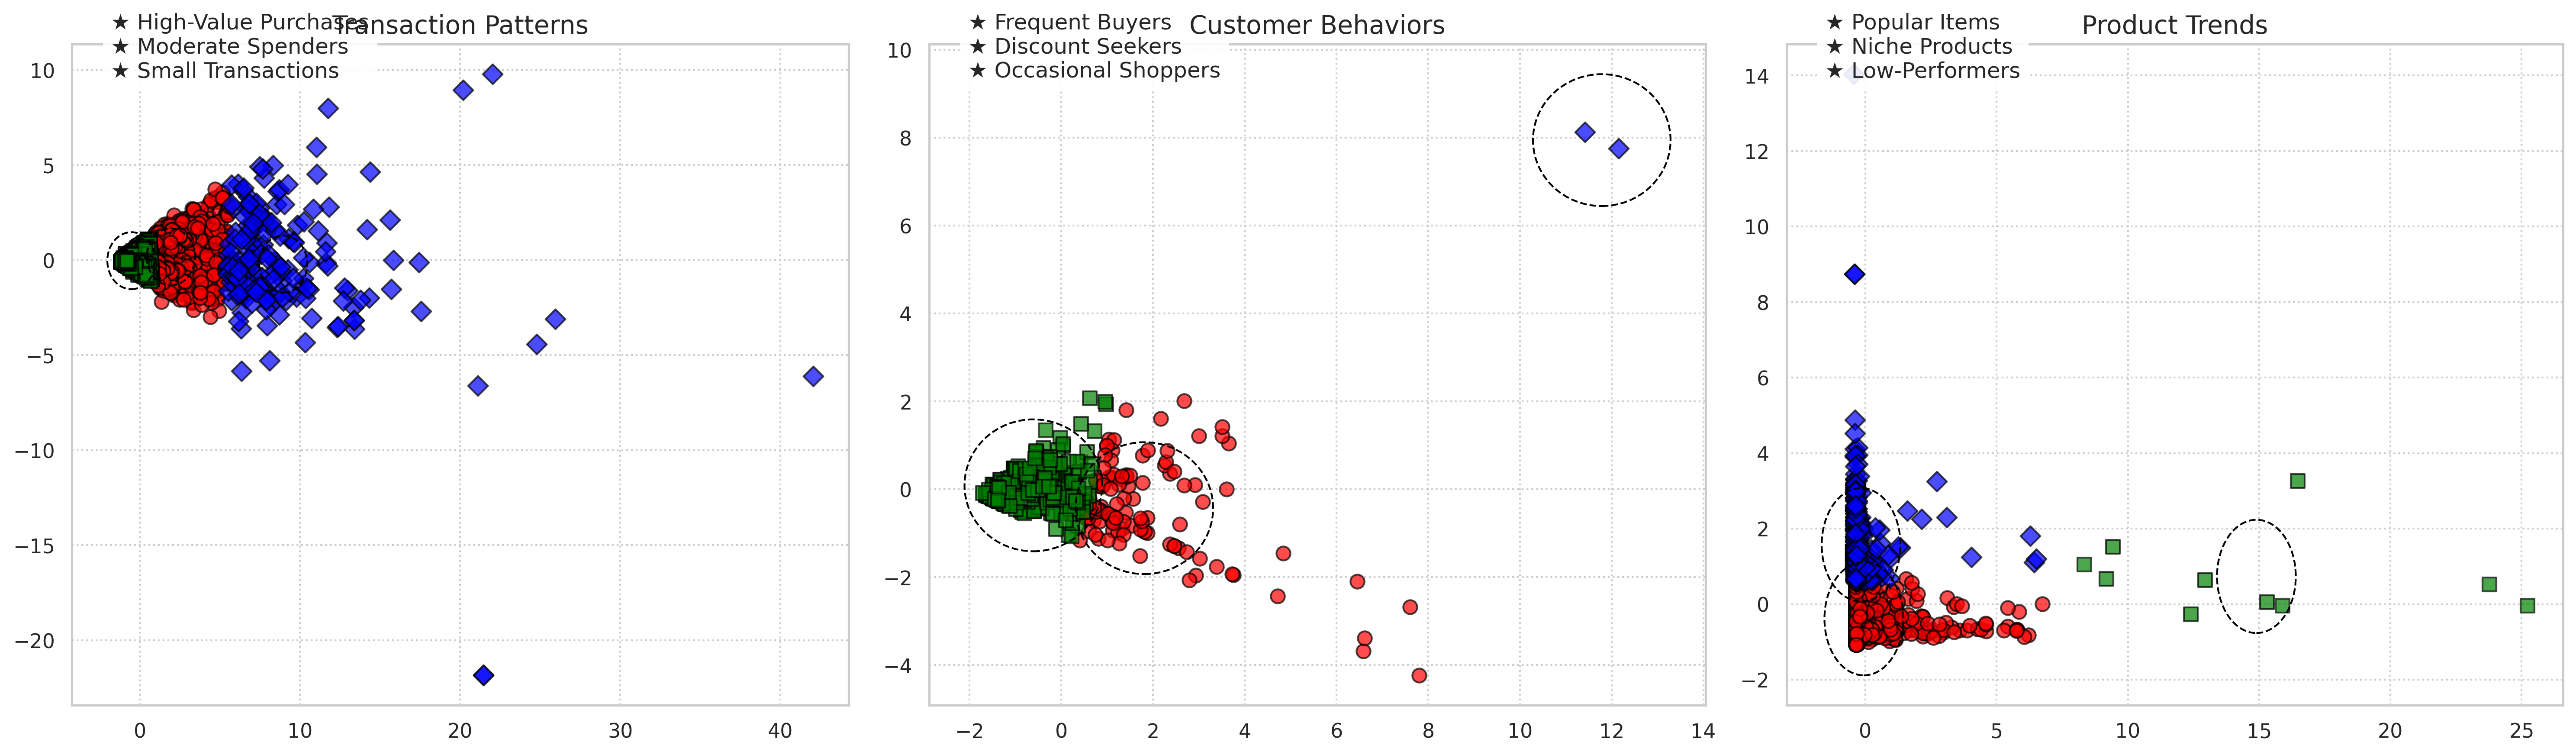

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Load and preprocess data
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(dataset_path, csv_file), parse_dates=['Date'])
df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})

# Create three different cluster perspectives
def create_clusters(data, features, n_clusters=3):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data[features])
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(scaled)
    return pca_data, kmeans, pca

# 1. Transaction Value Clusters
trans_features = ['TotalSales', 'Quantity', 'Discount']
trans_pca, trans_kmeans, trans_pca_model = create_clusters(df.groupby('InvoiceID').agg({
    'TotalSales': 'sum', 'Quantity': 'sum', 'Discount': 'sum'
}).reset_index(), trans_features)

# 2. Customer Behavior Clusters
cust_features = ['TotalSales', 'Quantity', 'Discount']
cust_df = df.groupby('CustomerID').agg({
    'TotalSales': 'mean',
    'Quantity': 'mean',
    'Discount': 'mean'
}).reset_index()
cust_pca, cust_kmeans, cust_pca_model = create_clusters(cust_df, cust_features)

# 3. Product Popularity Clusters
prod_features = ['TotalSales', 'Quantity', 'Discount']
prod_df = df.groupby('ProductID').agg({
    'TotalSales': 'sum',
    'Quantity': 'count',
    'Discount': 'mean'
}).reset_index()
prod_pca, prod_kmeans, prod_pca_model = create_clusters(prod_df, prod_features)

# Create visual storytelling
plt.figure(figsize=(20, 6))
colors = ['red', 'green', 'blue']
titles = ['Transaction Patterns', 'Customer Behaviors', 'Product Trends']
datasets = [(trans_pca, trans_kmeans, trans_pca_model), (cust_pca, cust_kmeans, cust_pca_model), (prod_pca, prod_kmeans, prod_pca_model)]

for idx, (pca_data, model, pca_model) in enumerate(datasets, 1):
    plt.subplot(1, 3, idx)

    # Plot clustered points
    for i in range(3):
        plt.scatter(pca_data[model.labels_ == i, 0],
                    pca_data[model.labels_ == i, 1],
                    s=60, c=colors[i], edgecolor='black',
                    marker=['o', 's', 'D'][i],  # Corrected marker assignment
                    alpha=0.7)

    # Add cluster circles
    scaler = StandardScaler()

    if idx == 1:
        scaled_data = scaler.fit_transform(df.groupby('InvoiceID').agg({'TotalSales': 'sum', 'Quantity': 'sum', 'Discount': 'sum'}).reset_index()[trans_features])
    elif idx == 2:
        scaled_data = scaler.fit_transform(cust_df[cust_features])
    else:
        scaled_data = scaler.fit_transform(prod_df[prod_features])

    centers = pca_model.transform(model.cluster_centers_)
    for center in centers:
        plt.gca().add_patch(plt.Circle(center, 1.5,
                                     fill=False,
                                     linestyle='--',
                                     color='black'))

    # Add cluster stories
    story = {
        0: ["High-Value Purchases", "Frequent Buyers", "Popular Items"][idx-1],
        1: ["Moderate Spenders", "Discount Seekers", "Niche Products"][idx-1],
        2: ["Small Transactions", "Occasional Shoppers", "Low-Performers"][idx-1]
    }
    plt.text(0.05, 0.95, "\n".join([f"★ {story[i]}" for i in range(3)]),
             transform=plt.gca().transAxes,
             bbox=dict(facecolor='white', alpha=0.9))

    plt.title(titles[idx-1], fontsize=14)
    plt.grid(ls=':')

plt.tight_layout()
plt.show()

Loaded /root/.cache/kagglehub/datasets/shedai/retail-data-set/versions/2/file_out2.csv
Preprocessing data...
Data shape after initial cleaning: (28927, 8)

=== Perspective 1: Transaction Patterns ===

Finding optimal clusters using features: ['TotalSales', 'Quantity', 'Discount']
  k=2: Inertia=26212.66, Silhouette=0.707, Davies-Bouldin=0.907
  k=3: Inertia=19821.46, Silhouette=0.577, Davies-Bouldin=1.020
  k=4: Inertia=16500.66, Silhouette=0.595, Davies-Bouldin=0.911
  k=5: Inertia=13840.85, Silhouette=0.568, Davies-Bouldin=0.968
  k=6: Inertia=11331.17, Silhouette=0.571, Davies-Bouldin=0.857
  k=7: Inertia=9602.94, Silhouette=0.496, Davies-Bouldin=0.830


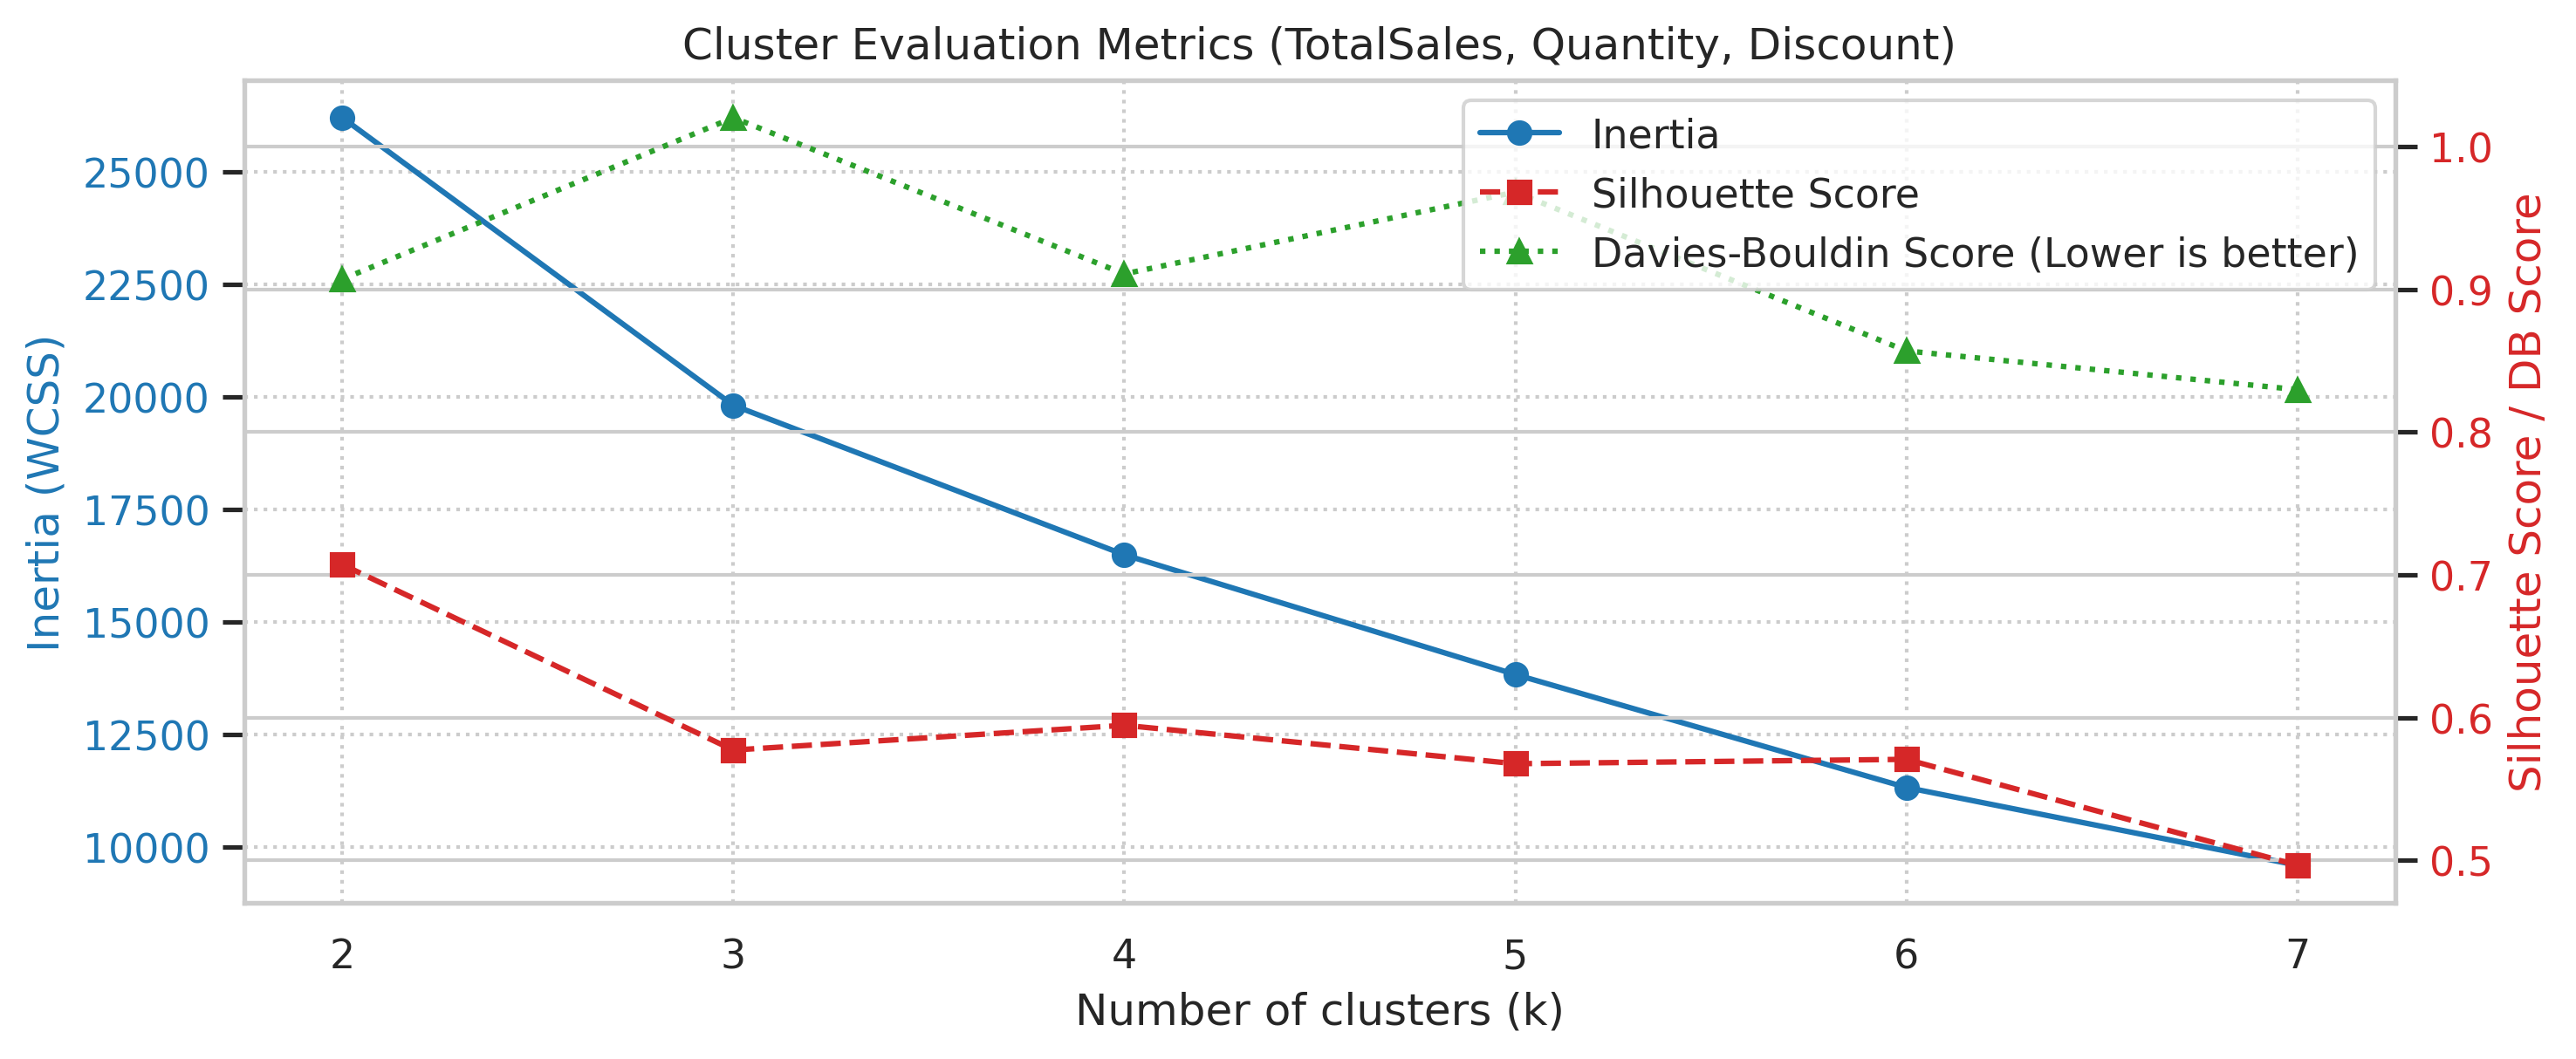

-> Suggested optimal k based on max Silhouette score: 2

Performing KMeans with k=2 using features: ['TotalSales', 'Quantity', 'Discount']
  Validation for k=2: Silhouette=0.707, Davies-Bouldin=0.907
Applying PCA...

--- Cluster Profiles ---

Cluster 0 (Size: 1226)
  Means:
TotalSales   22933.21
Quantity        45.48
Discount      1479.63

  Medians:
TotalSales   18434.75
Quantity        41.00
Discount      1057.02

Cluster 1 (Size: 12734)
  Means:
TotalSales   3626.08
Quantity        8.05
Discount      375.41

  Medians:
TotalSales   2436.06
Quantity        4.00
Discount      262.37
----------------------


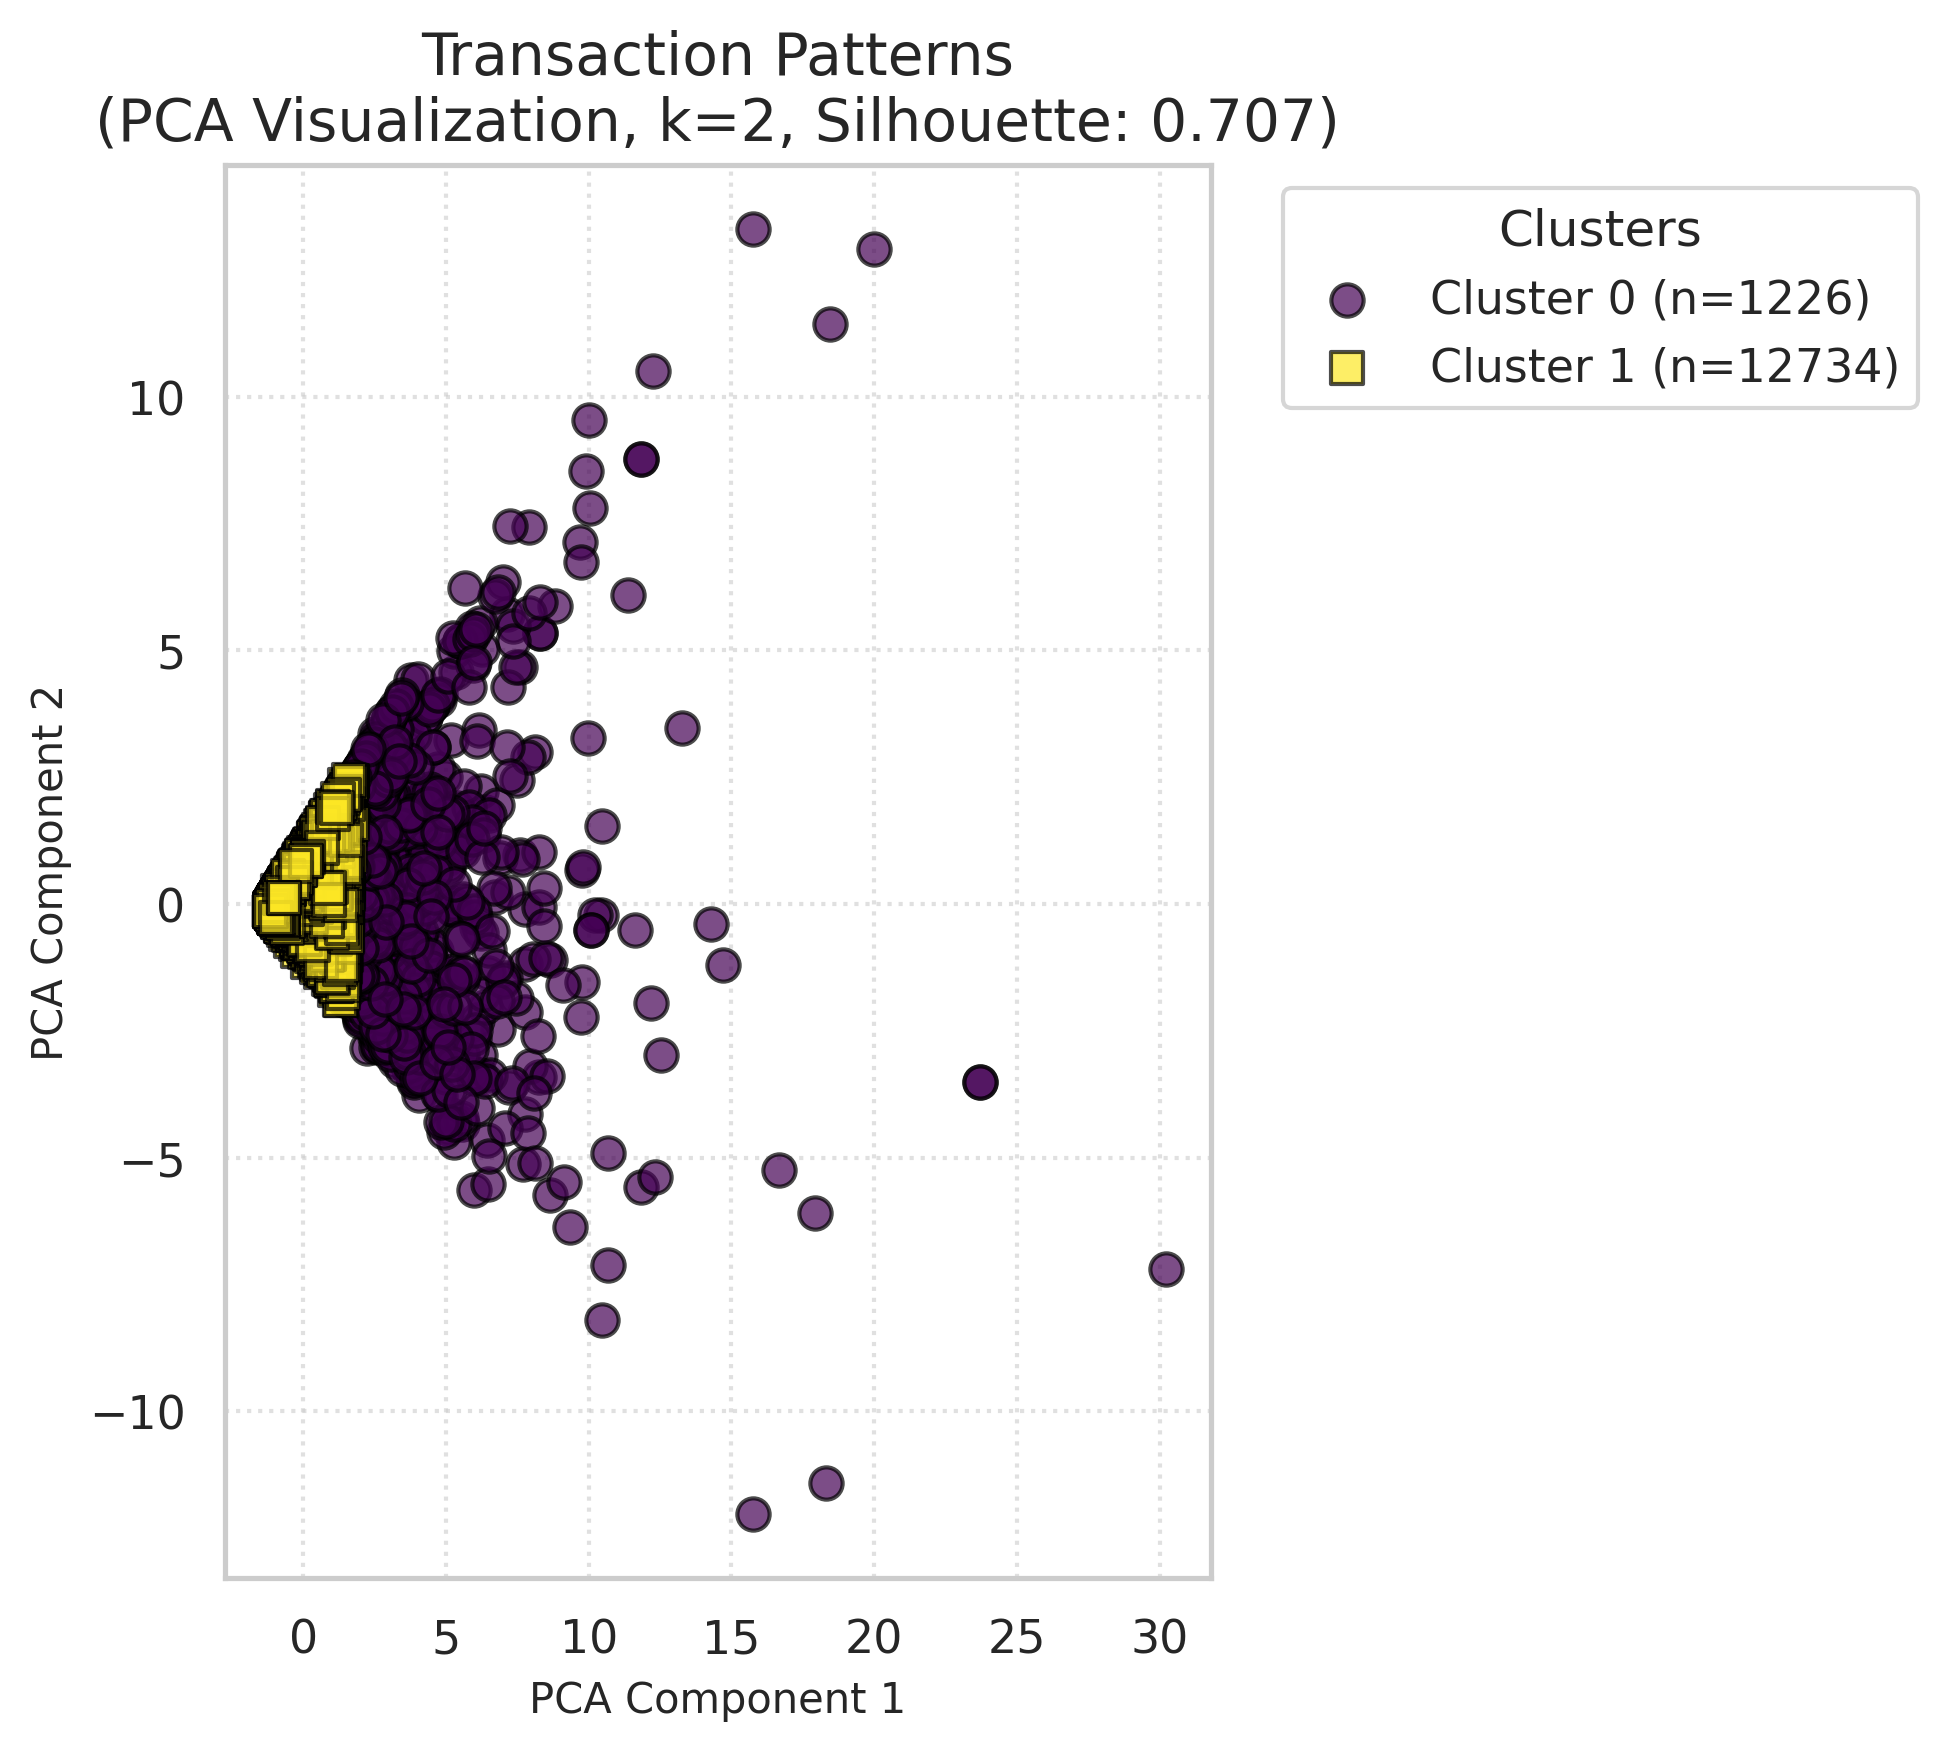


=== Perspective 2: Customer Segments (RFM) ===

Finding optimal clusters using features: ['Recency', 'Frequency', 'Monetary']
  k=2: Inertia=853.40, Silhouette=0.604, Davies-Bouldin=0.769
  k=3: Inertia=473.47, Silhouette=0.580, Davies-Bouldin=0.608
  k=4: Inertia=275.36, Silhouette=0.598, Davies-Bouldin=0.539
  k=5: Inertia=206.18, Silhouette=0.570, Davies-Bouldin=0.648
  k=6: Inertia=164.01, Silhouette=0.534, Davies-Bouldin=0.650
  k=7: Inertia=137.02, Silhouette=0.522, Davies-Bouldin=0.752


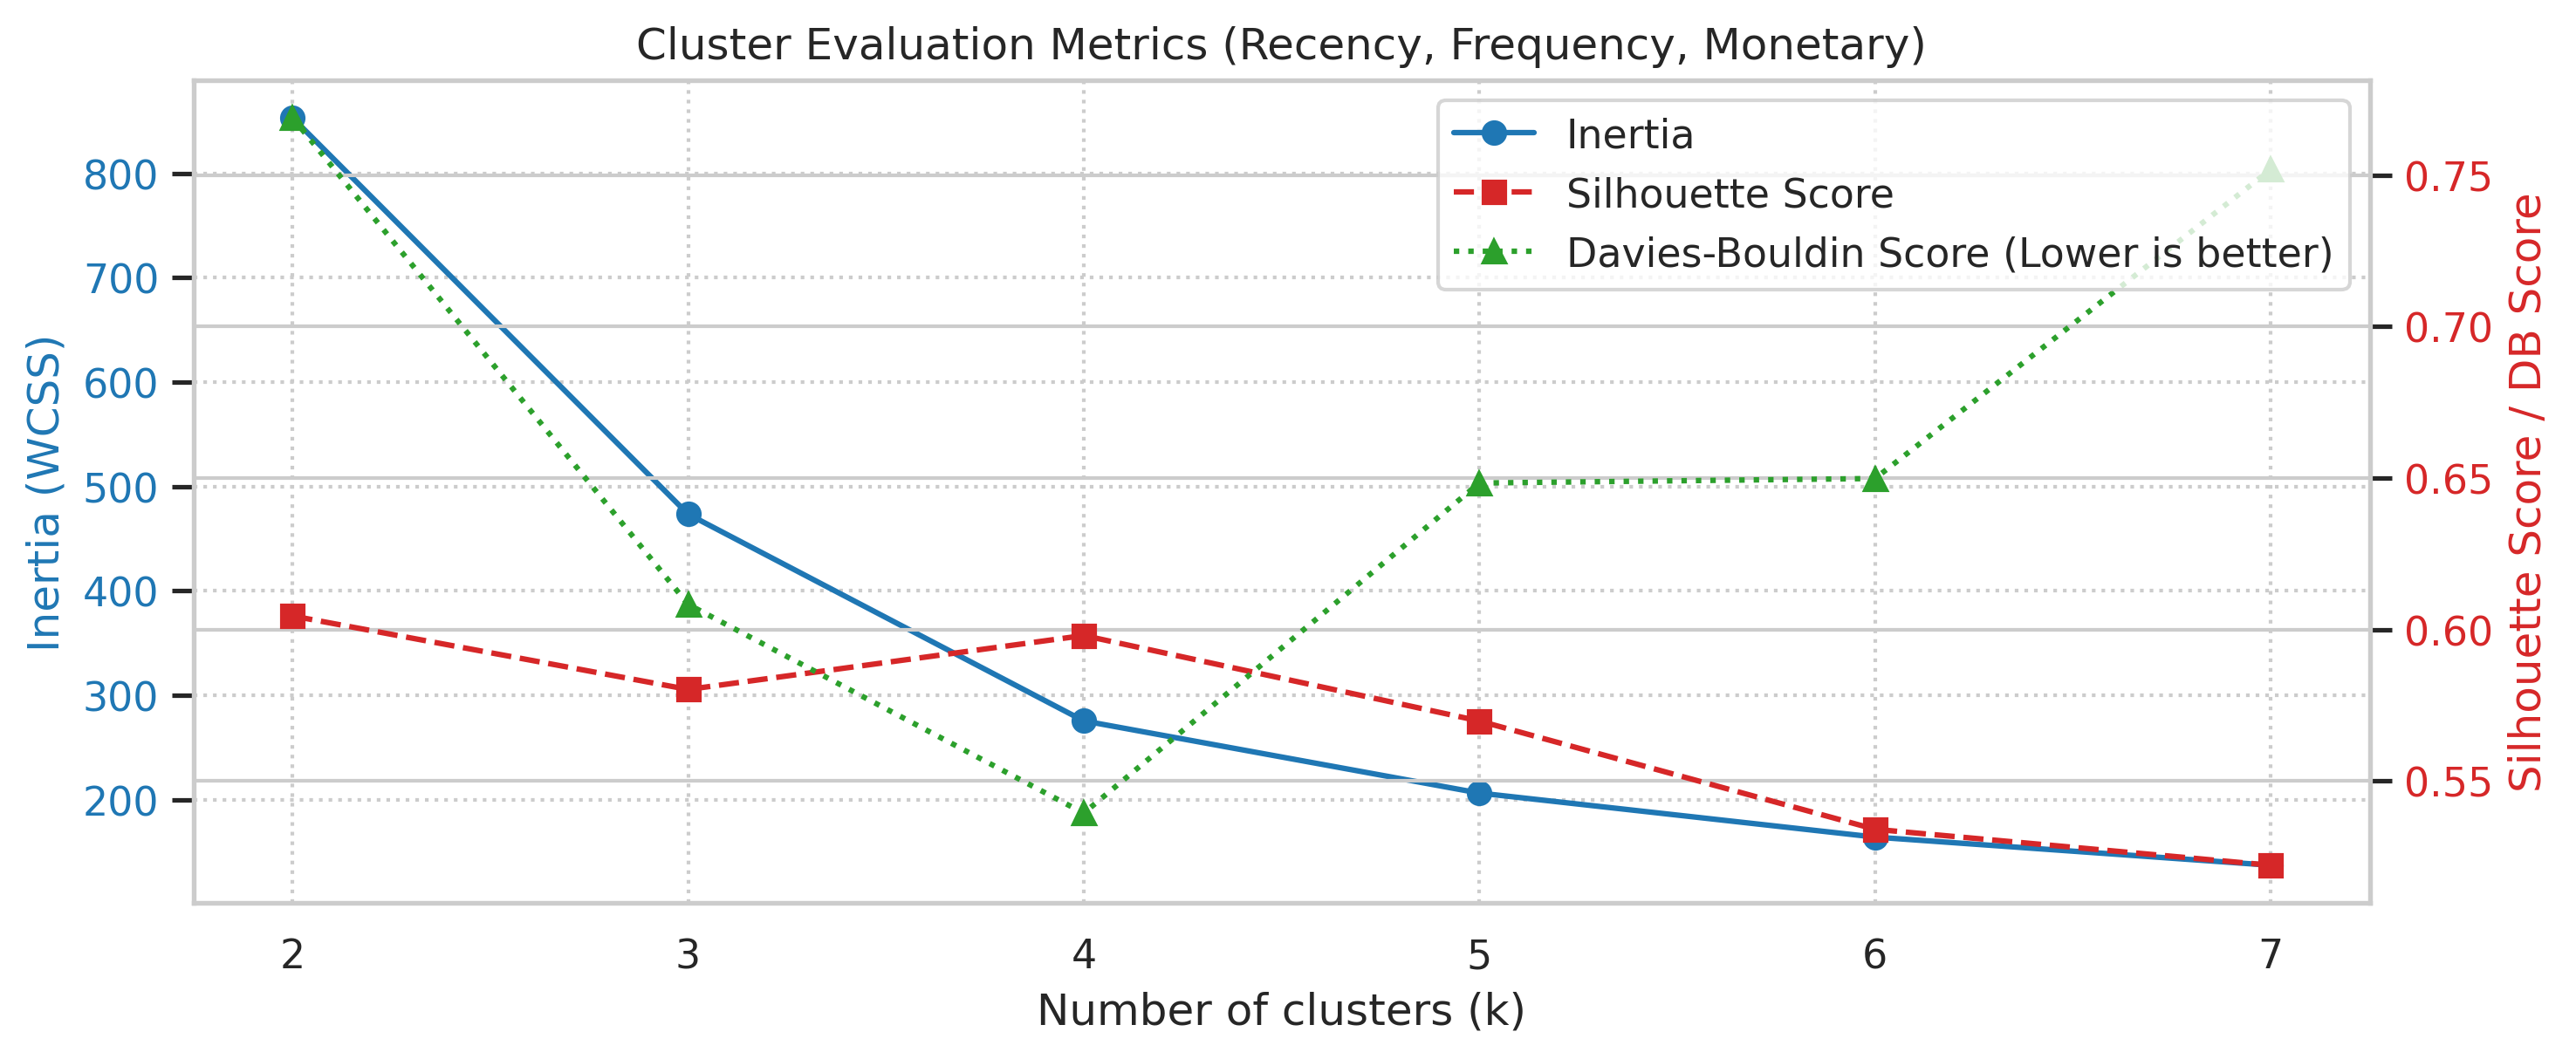

-> Suggested optimal k based on max Silhouette score: 2

Performing KMeans with k=2 using features: ['Recency', 'Frequency', 'Monetary']
  Validation for k=2: Silhouette=0.604, Davies-Bouldin=0.769
Applying PCA...

--- Cluster Profiles ---

Cluster 0 (Size: 69)
  Means:
Recency         35.12
Frequency      209.16
Monetary    847740.45

  Medians:
Recency         10.00
Frequency      182.00
Monetary    650123.03

Cluster 1 (Size: 438)
  Means:
Recency       565.74
Frequency      13.60
Monetary    36065.14

  Medians:
Recency      402.50
Frequency      2.00
Monetary    6279.56
----------------------


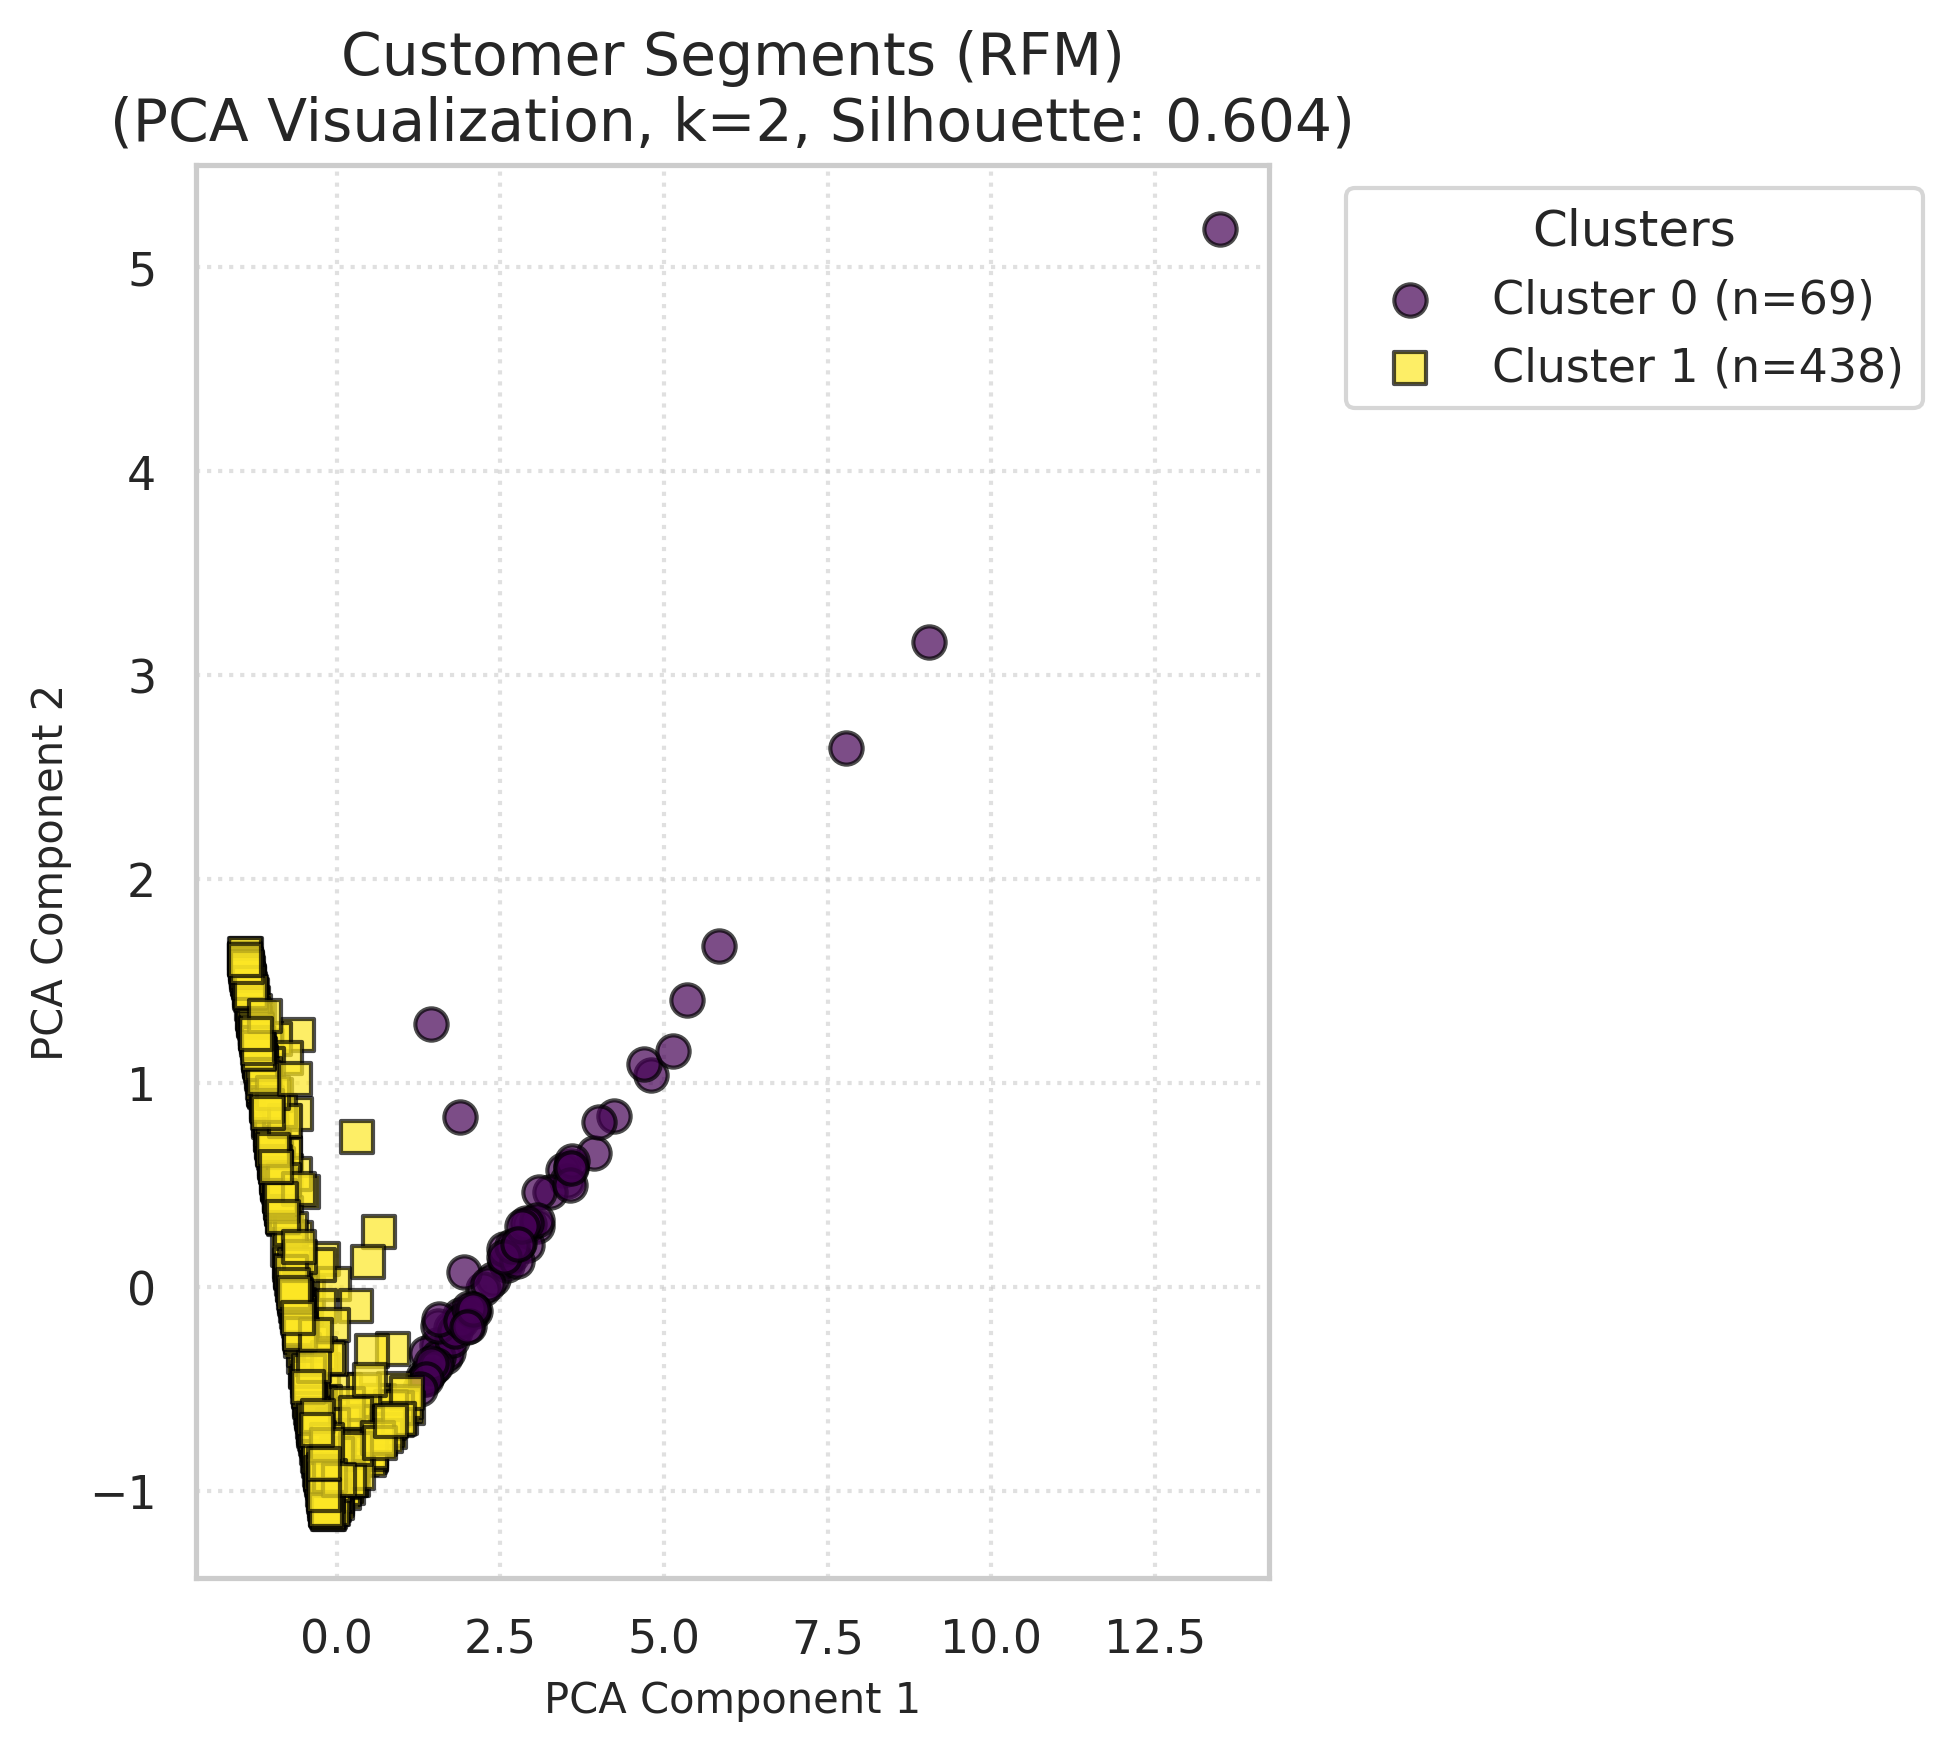


=== Perspective 3: Product Categories ===

Finding optimal clusters using features: ['TotalSales', 'Frequency', 'AvgDiscount']
  k=2: Inertia=3540.11, Silhouette=0.864, Davies-Bouldin=0.646
  k=3: Inertia=2387.94, Silhouette=0.573, Davies-Bouldin=0.667
  k=4: Inertia=1562.21, Silhouette=0.595, Davies-Bouldin=0.604
  k=5: Inertia=1258.98, Silhouette=0.507, Davies-Bouldin=0.636
  k=6: Inertia=1037.30, Silhouette=0.471, Davies-Bouldin=0.616
  k=7: Inertia=835.77, Silhouette=0.516, Davies-Bouldin=0.613


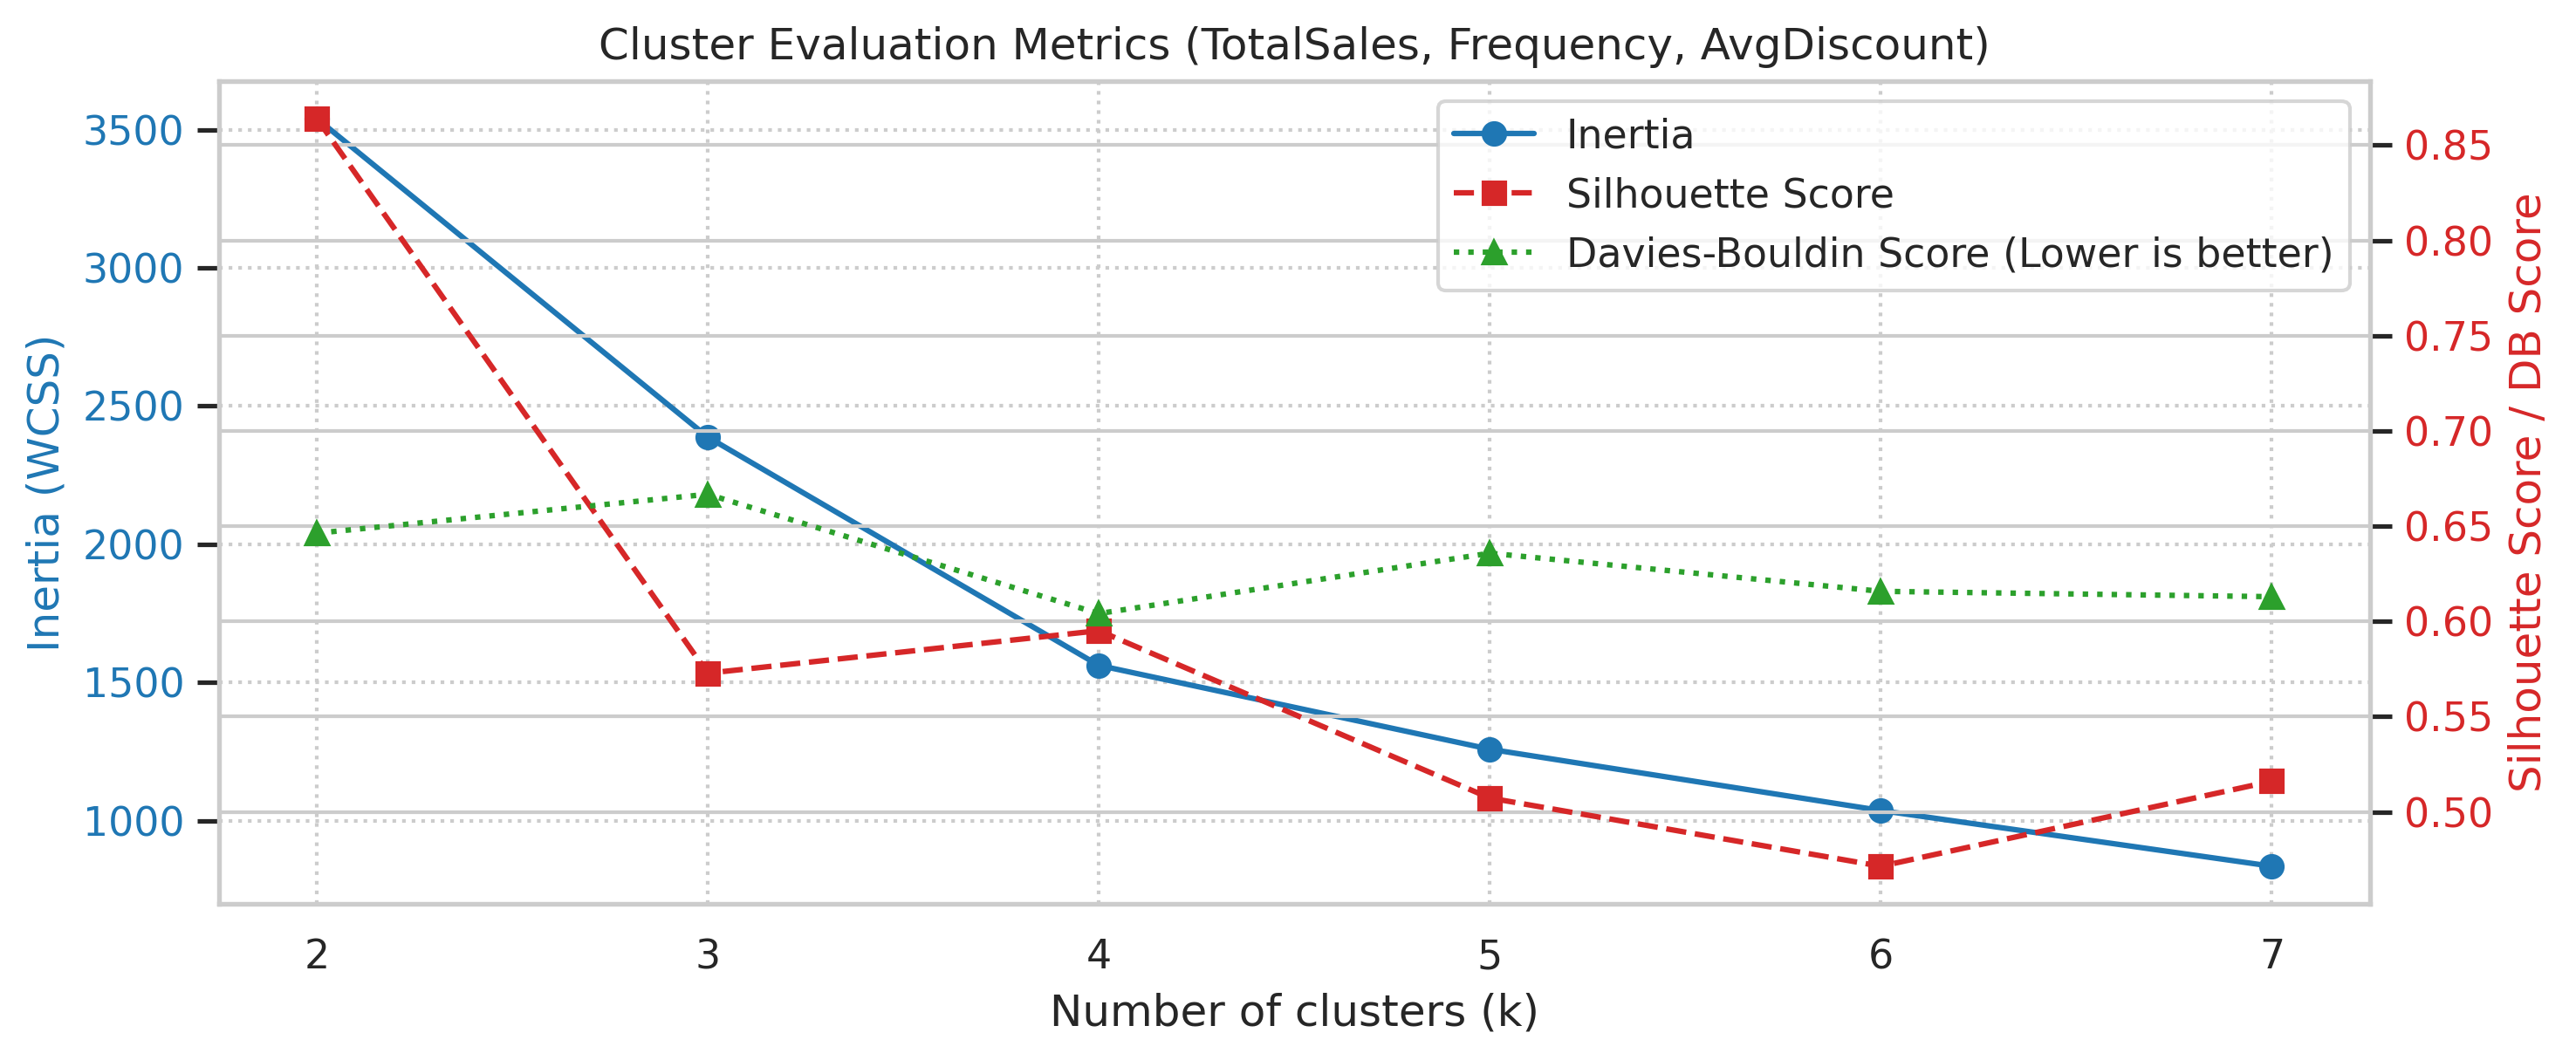

-> Suggested optimal k based on max Silhouette score: 2

Performing KMeans with k=2 using features: ['TotalSales', 'Frequency', 'AvgDiscount']
  Validation for k=2: Silhouette=0.864, Davies-Bouldin=0.646
Applying PCA...

--- Cluster Profiles ---

Cluster 0 (Size: 1912)
  Means:
TotalSales    24643.66
Frequency        10.21
AvgDiscount     606.62

  Medians:
TotalSales    8974.67
Frequency        3.00
AvgDiscount    426.25

Cluster 1 (Size: 28)
  Means:
TotalSales    970426.72
Frequency        312.36
AvgDiscount      560.99

  Medians:
TotalSales    670609.20
Frequency        257.50
AvgDiscount      422.16
----------------------


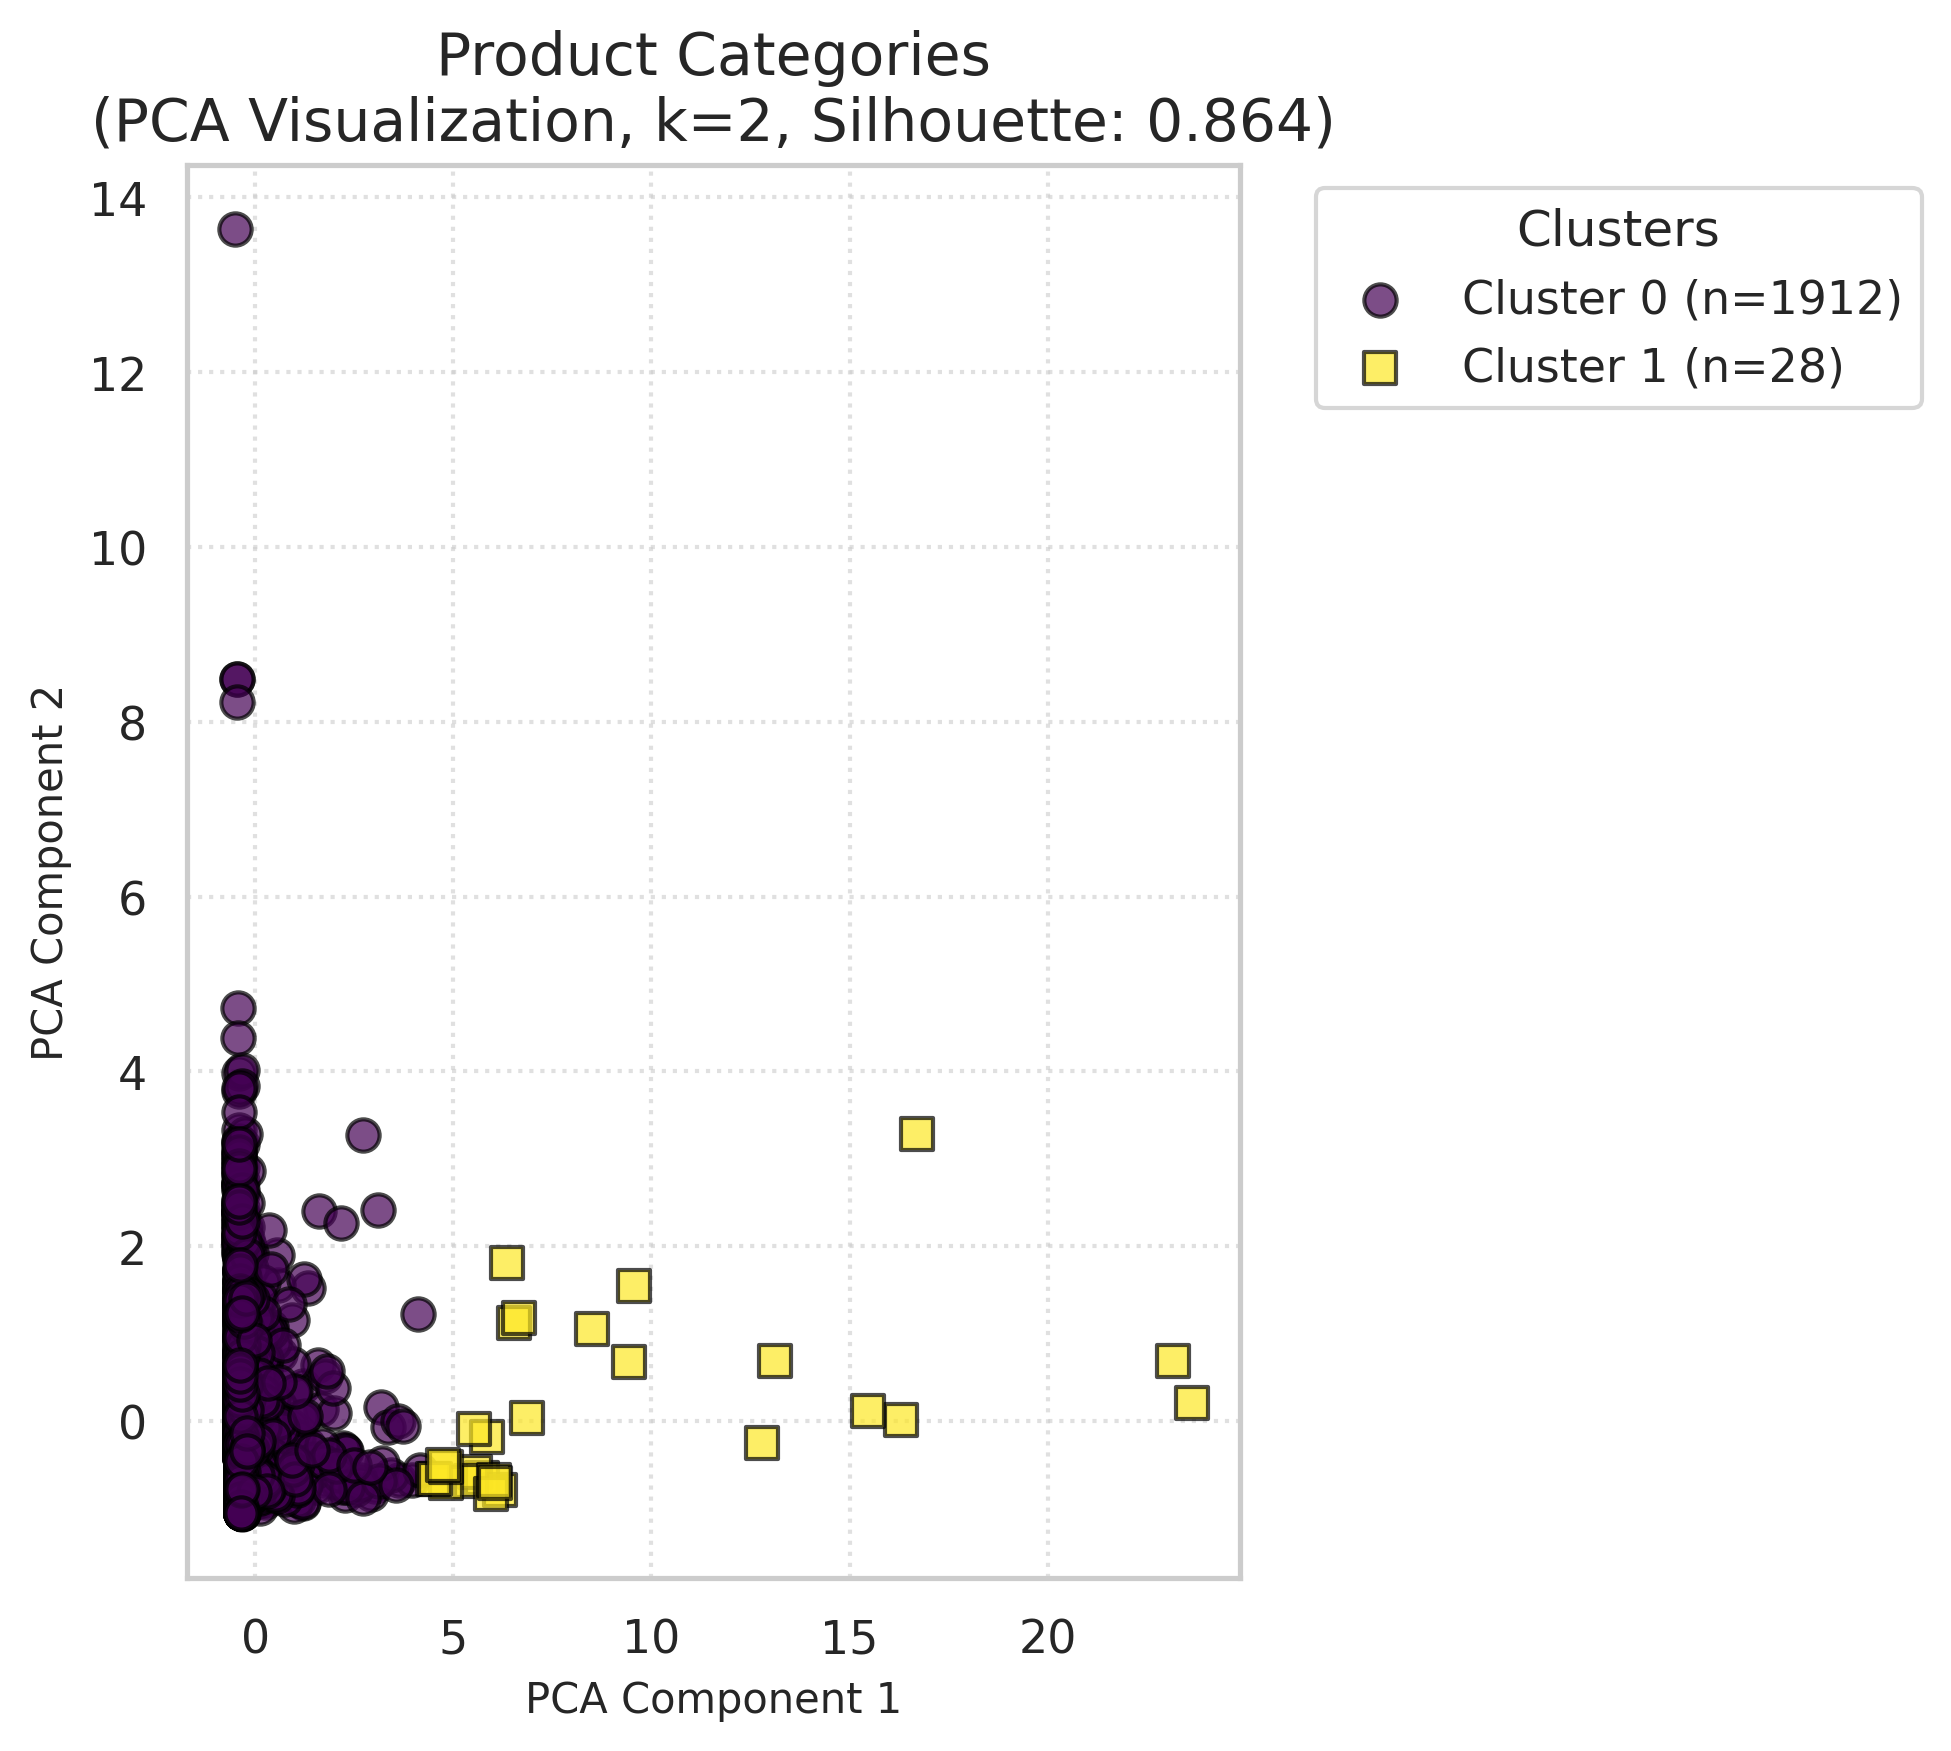


Analysis complete.


In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler # Added RobustScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE # Added t-SNE
from sklearn.metrics import silhouette_score, davies_bouldin_score # Added metrics
import os
import datetime as dt
import warnings

# --- Configuration ---
RANDOM_STATE = 42
N_CLUSTERS_OPTIONS = range(2, 8) # Range of k values to evaluate
DEFAULT_N_CLUSTERS = 3 # Default if optimal k finding is inconclusive
SCALER_TYPE = 'standard' # 'standard' or 'robust'
DIM_REDUCTION_VIS = 'pca' # 'pca' or 'tsne' for the main plot

# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')
warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn.cluster._kmeans') # For n_init default change

# --- Helper Functions ---

def find_optimal_clusters(data, feature_cols, k_options, scaler_type='standard', random_state=42):
    """Evaluates different numbers of clusters using Elbow and Silhouette methods."""
    print(f"\nFinding optimal clusters using features: {feature_cols}")
    if data.empty or not all(f in data.columns for f in feature_cols):
        print("Warning: Data is empty or features not found. Skipping optimal k search.")
        return {}

    X = data[feature_cols].copy()
    if (X.std() == 0).any():
        print(f"Warning: Constant columns found: {X.columns[X.std() == 0].tolist()}. Removing.")
        X = X.loc[:, X.std() != 0]
    if X.shape[1] == 0:
         print("Warning: No non-constant features remain. Skipping optimal k search.")
         return {}

    if scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    inertia_values = []
    silhouette_scores = []
    db_scores = []
    results = {}

    for k in k_options:
        if k > scaled_data.shape[0] -1 : # Need at least k+1 samples for silhouette
             print(f"Skipping k={k}, not enough samples ({scaled_data.shape[0]})")
             continue
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=random_state)
        kmeans.fit(scaled_data)
        inertia_values.append(kmeans.inertia_)
        try:
            sil_score = silhouette_score(scaled_data, kmeans.labels_)
            db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
            silhouette_scores.append(sil_score)
            db_scores.append(db_score)
            results[k] = {'inertia': kmeans.inertia_, 'silhouette': sil_score, 'db_score': db_score}
            print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")
        except ValueError as e:
            print(f"  k={k}: Could not calculate scores. Error: {e}")
            silhouette_scores.append(np.nan) # Append NaN if calculation fails
            db_scores.append(np.nan)
            results[k] = {'inertia': kmeans.inertia_, 'silhouette': np.nan, 'db_score': np.nan}


    # Plotting Elbow and Silhouette
    fig, ax1 = plt.subplots(figsize=(10, 4))

    # Inertia plot (Elbow)
    color = 'tab:blue'
    ax1.set_xlabel('Number of clusters (k)')
    ax1.set_ylabel('Inertia (WCSS)', color=color)
    ax1.plot(list(results.keys()), [r['inertia'] for r in results.values()], marker='o', color=color, label='Inertia')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle=':')

    # Silhouette plot
    ax2 = ax1.twinx() # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score / DB Score', color=color)
    valid_sil_keys = [k for k, r in results.items() if not np.isnan(r['silhouette'])]
    valid_sil_scores = [r['silhouette'] for k, r in results.items() if not np.isnan(r['silhouette'])]
    ax2.plot(valid_sil_keys, valid_sil_scores, marker='s', linestyle='--', color='tab:red', label='Silhouette Score')

    # Davies-Bouldin plot
    valid_db_keys = [k for k, r in results.items() if not np.isnan(r['db_score'])]
    valid_db_scores = [r['db_score'] for k, r in results.items() if not np.isnan(r['db_score'])]
    ax2.plot(valid_db_keys, valid_db_scores, marker='^', linestyle=':', color='tab:green', label='Davies-Bouldin Score (Lower is better)')

    ax2.tick_params(axis='y', labelcolor=color)


    fig.tight_layout() # otherwise the right y-label is slightly clipped
    plt.title(f'Cluster Evaluation Metrics ({", ".join(feature_cols)})')
    fig.legend(loc="upper right", bbox_to_anchor=(1,1), bbox_transform=ax1.transAxes)
    plt.show()

    # Suggest optimal k (simple heuristic: max silhouette)
    valid_scores = {k: r['silhouette'] for k, r in results.items() if not np.isnan(r['silhouette'])}
    if valid_scores:
        optimal_k_silhouette = max(valid_scores, key=valid_scores.get)
        print(f"-> Suggested optimal k based on max Silhouette score: {optimal_k_silhouette}")
    else:
        optimal_k_silhouette = None
        print("-> Could not determine optimal k from Silhouette score.")

    return results, optimal_k_silhouette


def perform_clustering(data, features, n_clusters, scaler_type='standard', random_state=42):
    """Performs scaling and K-Means clustering."""
    print(f"\nPerforming KMeans with k={n_clusters} using features: {features}")
    if data.empty or not all(f in data.columns for f in features):
        print("Warning: Data is empty or features not found. Skipping clustering.")
        return None, None, None

    X = data[features].copy()
    if (X.std() == 0).any():
        print(f"Warning: Constant columns found: {X.columns[X.std() == 0].tolist()}. Removing.")
        X = X.loc[:, X.std() != 0]
    if X.shape[1] == 0:
         print("Warning: No non-constant features remain. Skipping clustering.")
         return None, None, None
    if X.shape[0] < n_clusters:
        print(f"Warning: Number of samples ({X.shape[0]}) is less than n_clusters ({n_clusters}). Cannot perform clustering.")
        return None, None, None

    if scaler_type == 'robust':
        scaler = RobustScaler()
    else:
        scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=random_state)
    kmeans.fit(scaled_data)

    # Calculate validation scores for the chosen k
    try:
        sil_score = silhouette_score(scaled_data, kmeans.labels_)
        db_score = davies_bouldin_score(scaled_data, kmeans.labels_)
        print(f"  Validation for k={n_clusters}: Silhouette={sil_score:.3f}, Davies-Bouldin={db_score:.3f}")
    except ValueError:
        sil_score = np.nan
        db_score = np.nan
        print(f"  Could not calculate validation scores for k={n_clusters}")

    return kmeans, scaler, scaled_data, {'silhouette': sil_score, 'db_score': db_score}


def apply_dimensionality_reduction(scaled_data, method='pca', n_components=2, random_state=42):
    """Applies PCA or t-SNE for visualization."""
    print(f"Applying {method.upper()}...")
    if scaled_data is None or scaled_data.shape[1] < n_components:
        print(f"Warning: Not enough features ({scaled_data.shape[1] if scaled_data is not None else 0}) for {method.upper()}. Skipping.")
        return None, None

    if method == 'tsne':
        # t-SNE specific parameters (perplexity is important)
        perplexity = min(30, max(5, scaled_data.shape[0] // 4)) # Heuristic
        print(f"  Using perplexity={perplexity} for t-SNE")
        reducer = TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity, n_iter=300)
    else: # Default to PCA
        reducer = PCA(n_components=n_components, random_state=random_state)

    reduced_data = reducer.fit_transform(scaled_data)
    return reduced_data, reducer

def profile_clusters(data, features, labels, scaler, n_clusters):
    """Calculates and prints statistics for each cluster."""
    print("\n--- Cluster Profiles ---")
    if data.empty or labels is None:
        print("No data or labels to profile.")
        return

    profile_data = data[features].copy()
    profile_data['Cluster'] = labels

    # Calculate stats for each cluster
    cluster_profiles = profile_data.groupby('Cluster')[features].agg(['mean', 'median', 'std', 'count'])

    # Display profiles
    pd.set_option('display.float_format', lambda x: '%.2f' % x) # Format output
    for i in range(n_clusters):
        print(f"\nCluster {i} (Size: {cluster_profiles.loc[i, (features[0], 'count')]})") # Show size
        # Display means and medians (often useful)
        print("  Means:")
        print(cluster_profiles.loc[i].xs('mean', level=1).to_string())
        print("\n  Medians:")
        print(cluster_profiles.loc[i].xs('median', level=1).to_string())
        # Optionally display std dev: print(cluster_profiles.loc[i].xs('std', level=1))
    pd.reset_option('display.float_format')
    print("----------------------")
    return cluster_profiles


def plot_clustering_results(reduced_data, model, title, validation_scores, dim_reduction_method):
    """Plots the clustered data after dimensionality reduction."""
    if reduced_data is None or model is None:
        print(f"Skipping plot for '{title}' due to missing data or model.")
        return None # Indicate plot was skipped

    plt.figure(figsize=(8, 6))
    n_clusters = model.n_clusters
    labels = model.labels_
    scatter_colors = plt.cm.viridis(np.linspace(0, 1, n_clusters))
    markers = ['o', 's', 'D', 'v', '^', '<', '>'] # More markers

    for i in range(n_clusters):
        cluster_points = reduced_data[labels == i]
        plt.scatter(cluster_points[:, 0],
                    cluster_points[:, 1],
                    s=60, c=[scatter_colors[i]], # Pass color as list for single points
                    edgecolor='black',
                    marker=markers[i % len(markers)],
                    alpha=0.7,
                    label=f'Cluster {i} (n={len(cluster_points)})') # Add size to label

    # Optional: Plot centroids if PCA was used and centroids exist
    # if dim_reduction_method == 'pca' and hasattr(model, 'cluster_centers_'):
    #      try:
    #          # Note: reducer object needed here if called outside main loop
    #          # centers_reduced = pca_model.transform(model.cluster_centers_) # Needs pca_model
    #          # plt.scatter(centers_reduced[:, 0], centers_reduced[:, 1], marker='X', s=200, c='red', edgecolor='black', label='Centroids')
    #          pass # Centroids less meaningful in t-SNE space
    #      except Exception as e:
    #          print(f"Warning: Could not plot centroids. Error: {e}")

    plt.title(f"{title}\n({dim_reduction_method.upper()} Visualization, k={n_clusters}, Silhouette: {validation_scores.get('silhouette', np.nan):.3f})", fontsize=14)
    plt.xlabel(f"{dim_reduction_method.upper()} Component 1", fontsize=10)
    plt.ylabel(f"{dim_reduction_method.upper()} Component 2", fontsize=10)
    plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Adjust layout for legend
    return plt # Return the plot object


# --- Main Script ---

# 1. Load and Preprocess Data
print("Downloading and loading dataset...")
try:
    dataset_path = kagglehub.dataset_download("shedai/retail-data-set") # Specify version if needed
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    if not csv_files: raise FileNotFoundError(f"No CSV file found in {dataset_path}")
    file_path = os.path.join(dataset_path, csv_files[0])
    df = pd.read_csv(file_path, parse_dates=['Date'])
    print(f"Loaded {file_path}")

    print("Preprocessing data...")
    df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})
    df.dropna(subset=['CustomerID', 'InvoiceID'], inplace=True) # Need these IDs
    df['CustomerID'] = df['CustomerID'].astype(int)
    numeric_cols = ['TotalSales', 'Quantity', 'Discount']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=numeric_cols, inplace=True)
    df = df[(df['Quantity'] > 0) & (df['TotalSales'] > 0)] # Keep only positive sales/quantities
    print(f"Data shape after initial cleaning: {df.shape}")

except Exception as e:
    print(f"Fatal Error during data loading/preprocessing: {e}")
    exit()

# --- Perspective 1: Transaction Value Clusters ---
print("\n=== Perspective 1: Transaction Patterns ===")
trans_features = ['TotalSales', 'Quantity', 'Discount']
trans_grouped = df.groupby('InvoiceID').agg(
    TotalSales=('TotalSales', 'sum'),
    Quantity=('Quantity', 'sum'),
    Discount=('Discount', 'mean') # Mean discount per transaction
).reset_index()

# Find optimal k
trans_eval_results, trans_optimal_k = find_optimal_clusters(trans_grouped, trans_features, N_CLUSTERS_OPTIONS, SCALER_TYPE, RANDOM_STATE)
trans_k = trans_optimal_k if trans_optimal_k else DEFAULT_N_CLUSTERS

# Perform clustering
trans_kmeans, trans_scaler, trans_scaled, trans_scores = perform_clustering(
    trans_grouped, trans_features, trans_k, SCALER_TYPE, RANDOM_STATE
)

# Dimensionality reduction and plotting
if trans_kmeans:
    trans_reduced, trans_reducer = apply_dimensionality_reduction(trans_scaled, DIM_REDUCTION_VIS, random_state=RANDOM_STATE)
    plot_clustering_results(trans_reduced, trans_kmeans, "Transaction Patterns", trans_scores, DIM_REDUCTION_VIS)
    profile_clusters(trans_grouped, trans_features, trans_kmeans.labels_, trans_scaler, trans_k)
    plt.show() # Show plot for this perspective


# --- Perspective 2: Customer Behavior Clusters (RFM) ---
print("\n=== Perspective 2: Customer Segments (RFM) ===")
# Calculate Recency, Frequency, Monetary
snapshot_date = df['Date'].max() + dt.timedelta(days=1) # Day after last transaction
rfm_grouped = df.groupby('CustomerID').agg(
    Recency=('Date', lambda x: (snapshot_date - x.max()).days),
    Frequency=('InvoiceID', 'nunique'),
    Monetary=('TotalSales', 'sum')
).reset_index()

rfm_features = ['Recency', 'Frequency', 'Monetary']

# Find optimal k (Handle potential skewness in RFM - log transform maybe needed for better clustering)
# Optional: Log transform RFM values before finding k / clustering if highly skewed
# rfm_grouped_log = rfm_grouped.copy()
# for col in ['Frequency', 'Monetary']: # Recency is often okay, or needs different handling
#     rfm_grouped_log[col] = np.log1p(rfm_grouped_log[col])
# cust_eval_results, cust_optimal_k = find_optimal_clusters(rfm_grouped_log, rfm_features, N_CLUSTERS_OPTIONS, SCALER_TYPE, RANDOM_STATE)

cust_eval_results, cust_optimal_k = find_optimal_clusters(rfm_grouped, rfm_features, N_CLUSTERS_OPTIONS, SCALER_TYPE, RANDOM_STATE)
cust_k = cust_optimal_k if cust_optimal_k else DEFAULT_N_CLUSTERS

# Perform clustering
cust_kmeans, cust_scaler, cust_scaled, cust_scores = perform_clustering(
    rfm_grouped, rfm_features, cust_k, SCALER_TYPE, RANDOM_STATE
    # Use rfm_grouped_log here if you log-transformed
)

# Dimensionality reduction and plotting
if cust_kmeans:
    cust_reduced, cust_reducer = apply_dimensionality_reduction(cust_scaled, DIM_REDUCTION_VIS, random_state=RANDOM_STATE)
    plot_clustering_results(cust_reduced, cust_kmeans, "Customer Segments (RFM)", cust_scores, DIM_REDUCTION_VIS)
    # Profile using the original RFM values for interpretability
    profile_clusters(rfm_grouped, rfm_features, cust_kmeans.labels_, cust_scaler, cust_k)
    plt.show()


# --- Perspective 3: Product Popularity Clusters ---
print("\n=== Perspective 3: Product Categories ===")
prod_features_selected = ['TotalSales', 'Frequency', 'AvgDiscount']
prod_grouped = df.groupby('ProductID').agg(
    TotalSales=('TotalSales', 'sum'),
    Frequency=('InvoiceID', 'nunique'), # How many unique transactions included this product
    AvgDiscount=('Discount', 'mean')
).reset_index()
# Add total quantity sold as another potential feature
prod_quant = df.groupby('ProductID')['Quantity'].sum().reset_index().rename(columns={'Quantity':'TotalQuantity'})
prod_grouped = pd.merge(prod_grouped, prod_quant, on='ProductID', how='left')
# prod_features_selected.append('TotalQuantity') # Optionally add

# Find optimal k
prod_eval_results, prod_optimal_k = find_optimal_clusters(prod_grouped, prod_features_selected, N_CLUSTERS_OPTIONS, SCALER_TYPE, RANDOM_STATE)
prod_k = prod_optimal_k if prod_optimal_k else DEFAULT_N_CLUSTERS

# Perform clustering
prod_kmeans, prod_scaler, prod_scaled, prod_scores = perform_clustering(
    prod_grouped, prod_features_selected, prod_k, SCALER_TYPE, RANDOM_STATE
)

# Dimensionality reduction and plotting
if prod_kmeans:
    prod_reduced, prod_reducer = apply_dimensionality_reduction(prod_scaled, DIM_REDUCTION_VIS, random_state=RANDOM_STATE)
    plot_clustering_results(prod_reduced, prod_kmeans, "Product Categories", prod_scores, DIM_REDUCTION_VIS)
    profile_clusters(prod_grouped, prod_features_selected, prod_kmeans.labels_, prod_scaler, prod_k)
    plt.show()


print("\nAnalysis complete.")

<ipython-input-21-87b43d5446e5>:96: UserWarning:

Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 9733 (\N{BLACK STAR}) missing from font(s) Liberation Sans.



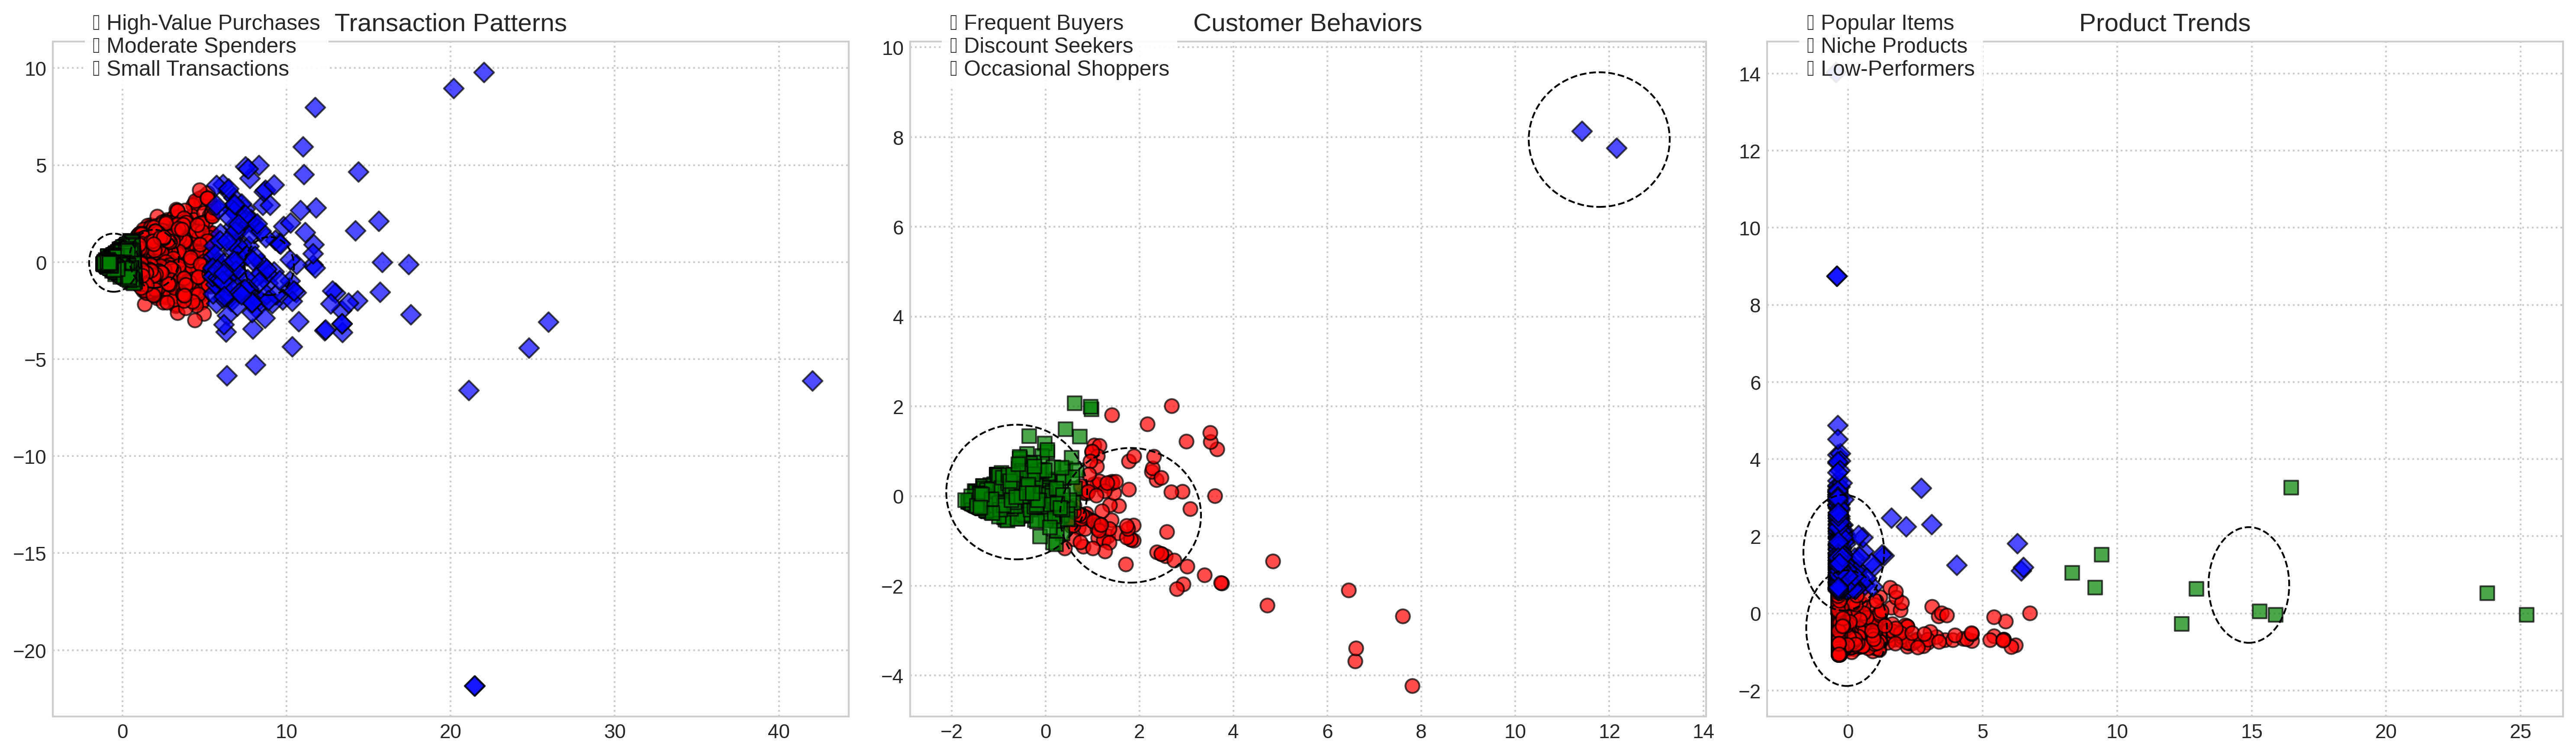

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import warnings

# Suppress specific warnings if desired (optional)
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn.cluster._kmeans')


# Load and preprocess data
print("Downloading dataset...")
try:
    # Use a specific version for reproducibility if needed
    dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
    print(f"Dataset downloaded to: {dataset_path}")

    # Find the CSV file robustly
    csv_files = [f for f in os.listdir(dataset_path) if f.endswith('.csv')]
    if not csv_files:
        raise FileNotFoundError(f"No CSV file found in {dataset_path}")
    csv_file = csv_files[0] # Assume the first CSV is the correct one
    file_path = os.path.join(dataset_path, csv_file)
    print(f"Loading data from: {file_path}")
    df = pd.read_csv(file_path, parse_dates=['Date'])

    # Basic Data Cleaning & Preprocessing
    print("Initial shape:", df.shape)
    df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})

    # Handle potential missing values (example: drop rows with missing CustomerID for customer clustering)
    df.dropna(subset=['CustomerID'], inplace=True)
    # Ensure numeric types where needed
    df['CustomerID'] = df['CustomerID'].astype(int)
    df['TotalSales'] = pd.to_numeric(df['TotalSales'], errors='coerce')
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df['Discount'] = pd.to_numeric(df['Discount'], errors='coerce')
    df.dropna(subset=['TotalSales', 'Quantity', 'Discount'], inplace=True) # Drop rows if key numeric values are missing after coercion
    # Filter out potential outliers or non-positive values if necessary (depends on analysis goals)
    df = df[(df['Quantity'] > 0) & (df['TotalSales'] > 0)]
    print("Shape after cleaning:", df.shape)


except Exception as e:
    print(f"Error during data loading/preprocessing: {e}")
    exit() # Exit if data loading fails


# --- Clustering Function ---
def create_clusters(data, features, n_clusters=3, random_state=42):
    """
    Performs scaling, PCA, and K-Means clustering.

    Args:
        data (pd.DataFrame): Input dataframe (usually grouped).
        features (list): List of column names to use for clustering.
        n_clusters (int): Number of clusters for KMeans.
        random_state (int): Random state for reproducibility.

    Returns:
        tuple: (pca_data, kmeans_model, pca_model, scaler_model)
               - pca_data: Data transformed by PCA (2 components).
               - kmeans_model: Fitted KMeans model.
               - pca_model: Fitted PCA model.
               - scaler_model: Fitted StandardScaler model.
    """
    if data.empty or not all(f in data.columns for f in features):
        print(f"Warning: Data is empty or features {features} not found. Skipping clustering.")
        return None, None, None, None

    X = data[features].copy() # Work on a copy

    # Check for constant columns which cause issues with scaling/PCA
    if (X.std() == 0).any():
        print(f"Warning: Constant columns found in features: {X.columns[X.std() == 0].tolist()}. Removing them.")
        X = X.loc[:, X.std() != 0]
        if X.shape[1] < 2:
             print("Warning: Less than 2 non-constant features remain. Cannot perform PCA. Skipping clustering.")
             return None, None, None, None

    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(X)

    # Adjust PCA components if fewer features remain after removing constant ones
    n_components = min(2, scaled_data.shape[1])
    pca = PCA(n_components=n_components, random_state=random_state)
    pca_data = pca.fit_transform(scaled_data)

    # Adjust n_clusters if number of samples is less than n_clusters
    actual_n_clusters = min(n_clusters, scaled_data.shape[0])
    if actual_n_clusters < n_clusters:
        print(f"Warning: Number of samples ({scaled_data.shape[0]}) is less than desired clusters ({n_clusters}). Using {actual_n_clusters} clusters.")
        if actual_n_clusters < 2: # Cannot cluster if less than 2 samples/clusters
             print("Warning: Not enough samples to form clusters. Skipping clustering.")
             return None, None, None, None


    kmeans = KMeans(n_clusters=actual_n_clusters, n_init=10, random_state=random_state)
    kmeans.fit(scaled_data)

    return pca_data, kmeans, pca, scaler

# --- Cluster Perspectives ---

print("\nCreating Transaction Value Clusters...")
# 1. Transaction Value Clusters
trans_features = ['TotalSales', 'Quantity', 'Discount']
trans_grouped = df.groupby('InvoiceID').agg(
    TotalSales=('TotalSales', 'sum'),
    Quantity=('Quantity', 'sum'),
    Discount=('Discount', 'sum') # Consider if sum or mean of discount per transaction makes more sense
).reset_index()
trans_pca, trans_kmeans, trans_pca_model, trans_scaler = create_clusters(trans_grouped, trans_features)

print("\nCreating Customer Behavior Clusters...")
# 2. Customer Behavior Clusters
cust_features = ['TotalSales', 'Quantity', 'Discount']
# Add frequency (number of invoices) as another potential feature
cust_grouped = df.groupby('CustomerID').agg(
    TotalSales=('TotalSales', 'mean'), # Average spend per item/transaction line
    Quantity=('Quantity', 'mean'),     # Average quantity per item/transaction line
    Discount=('Discount', 'mean'),     # Average discount per item/transaction line
    Frequency=('InvoiceID', 'nunique') # Number of unique transactions
).reset_index()
# Add Monetary value (Total spend per customer)
cust_total_sales = df.groupby('CustomerID')['TotalSales'].sum().reset_index().rename(columns={'TotalSales': 'Monetary'})
cust_grouped = pd.merge(cust_grouped, cust_total_sales, on='CustomerID', how='left')

# Select features for customer clustering (can experiment here)
# cust_features_selected = ['TotalSales', 'Quantity', 'Discount', 'Frequency', 'Monetary']
cust_features_selected = ['Monetary', 'Frequency', 'Discount'] # RFM style features often work well
cust_pca, cust_kmeans, cust_pca_model, cust_scaler = create_clusters(cust_grouped, cust_features_selected)


print("\nCreating Product Popularity Clusters...")
# 3. Product Popularity Clusters
prod_features = ['TotalSales', 'Quantity', 'Discount']
prod_grouped = df.groupby('ProductID').agg(
    TotalSales=('TotalSales', 'sum'),    # Total revenue from product
    Quantity=('Quantity', 'count'),     # Number of times product was sold (frequency)
    Discount=('Discount', 'mean')      # Average discount given for the product
).reset_index()
# Rename 'Quantity' count to 'Frequency' for clarity
prod_grouped = prod_grouped.rename(columns={'Quantity': 'Frequency'})
prod_features_selected = ['TotalSales', 'Frequency', 'Discount']
prod_pca, prod_kmeans, prod_pca_model, prod_scaler = create_clusters(prod_grouped, prod_features_selected)


# --- Visual Storytelling ---
print("\nGenerating visualization...")
plt.style.use('seaborn-v0_8-whitegrid') # Use a clean style
plt.figure(figsize=(22, 7)) # Adjusted figure size

colors = plt.cm.viridis(np.linspace(0, 1, 3)) # Use a colormap for potentially better distinction
markers = ['o', 's', 'D']
titles = ['Transaction Patterns (Value, Quantity, Discount)',
          'Customer Segments (Monetary, Frequency, Avg Discount)',
          'Product Categories (Total Sales, Frequency, Avg Discount)']

# Ensure we have data for all perspectives before trying to plot
datasets = []
if trans_pca is not None:
    datasets.append((trans_pca, trans_kmeans, trans_pca_model, trans_scaler, trans_grouped, trans_features))
else:
    print("Skipping plot for Transaction Patterns due to clustering issues.")

if cust_pca is not None:
    datasets.append((cust_pca, cust_kmeans, cust_pca_model, cust_scaler, cust_grouped, cust_features_selected))
else:
    print("Skipping plot for Customer Segments due to clustering issues.")

if prod_pca is not None:
    datasets.append((prod_pca, prod_kmeans, prod_pca_model, prod_scaler, prod_grouped, prod_features_selected))
else:
    print("Skipping plot for Product Categories due to clustering issues.")


# Check if there's anything to plot
if not datasets:
    print("No valid clustering results to plot. Exiting.")
    exit()

# Adjust subplot grid if some plots were skipped
num_plots = len(datasets)
fig, axes = plt.subplots(1, num_plots, figsize=(7 * num_plots, 6))
if num_plots == 1: # Handle case where only one plot is generated
    axes = [axes]

plot_index = 0 # Keep track of which dataset perspective we are plotting

for idx, (pca_data, model, pca_model, scaler_model, original_data, features_used) in enumerate(datasets):

    ax = axes[plot_index] # Get the current axis

    # --- Plot clustered points ---
    n_clusters_actual = model.n_clusters
    current_colors = plt.cm.viridis(np.linspace(0, 1, n_clusters_actual))

    for i in range(n_clusters_actual):
        cluster_points = pca_data[model.labels_ == i]
        ax.scatter(cluster_points[:, 0],
                   cluster_points[:, 1],
                   s=60, c=[current_colors[i]], # Ensure color is passed as a list/array for single colors
                   edgecolor='black',
                   marker=markers[i % len(markers)], # Cycle through markers if more than 3 clusters
                   alpha=0.7,
                   label=f'Cluster {i}') # Add label for legend


    # --- Add cluster centers and circles (Optional: Circles can be noisy) ---
    try:
        # Cluster centers are from the *scaled* space, transform them using PCA model
        centers_pca = pca_model.transform(model.cluster_centers_)
        ax.scatter(centers_pca[:, 0], centers_pca[:, 1],
                    marker='X', s=200, c='red', edgecolor='black', label='Centroids')

        # Optional: Add circles (adjust radius calculation as needed)
        # for i, center_pca in enumerate(centers_pca):
        #     # Calculate radius based on points in cluster (e.g., max distance to center in PCA space)
        #     cluster_points_pca = pca_data[model.labels_ == i]
        #     if len(cluster_points_pca) > 0:
        #         distances = np.sqrt(np.sum((cluster_points_pca - center_pca)**2, axis=1))
        #         radius = np.max(distances) * 1.1 # Add a small buffer
        #         ax.add_patch(plt.Circle(center_pca, radius,
        #                                  fill=False,
        #                                  linestyle='--',
        #                                  color='grey', alpha=0.6))
    except Exception as e:
        print(f"Warning: Could not plot centroids or circles for plot {plot_index + 1}. Error: {e}")


    # --- Add cluster stories/interpretations ---
    # Base stories - these might need adjustment based on actual cluster means
    base_story_map = {
        0: ["High Value/Quantity", "High Spenders/Frequent", "Top Sellers"],
        1: ["Medium Value/Quantity", "Average Spenders/Occasional", "Core Products"],
        2: ["Low Value/Quantity", "Low Spenders/Infrequent", "Niche/Slow Movers"],
    }

    # --- Dynamically generate story based on cluster means ---
    story_texts = []
    try:
        # Get cluster centers back in original scale
        centers_original_scale = scaler_model.inverse_transform(model.cluster_centers_)
        # Create a DataFrame for easier interpretation
        centers_df = pd.DataFrame(centers_original_scale, columns=features_used)
        centers_df['Cluster'] = range(n_clusters_actual)
        centers_df['Size'] = pd.Series(model.labels_).value_counts().sort_index()
        print(f"\n--- Cluster Interpretation for: {titles[idx]} ---")
        print(centers_df)


        # Generate simple qualitative labels based on means relative to overall mean
        overall_means = original_data[features_used].mean()
        for i in range(n_clusters_actual):
             cluster_mean = centers_df.iloc[i][features_used]
             interpretation = f"Cluster {i} ({centers_df.iloc[i]['Size']} members): "
             parts = []
             for feature in features_used:
                 if cluster_mean[feature] > overall_means[feature] * 1.2: # Significantly above average
                     parts.append(f"High {feature}")
                 elif cluster_mean[feature] < overall_means[feature] * 0.8: # Significantly below average
                     parts.append(f"Low {feature}")
                 else:
                     parts.append(f"Avg {feature}")
             interpretation += ", ".join(parts)
             story_texts.append(interpretation)

             # You could replace this dynamic interpretation with the predefined 'base_story_map'
             # if you prefer fixed labels, e.g., story_texts.append(f"Cluster {i}: {base_story_map[i % 3][idx]}")

    except Exception as e:
         print(f"Warning: Could not generate dynamic story for plot {plot_index + 1}. Error: {e}")
         # Fallback to generic labels if interpretation fails
         story_texts = [f"Cluster {i}" for i in range(n_clusters_actual)]


    # Position text box
    ax.text(0.02, 0.98, "\n".join(story_texts),
             transform=ax.transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.8))

    ax.set_title(titles[idx], fontsize=14, fontweight='bold')
    ax.set_xlabel("PCA Component 1", fontsize=10)
    ax.set_ylabel("PCA Component 2", fontsize=10)
    ax.grid(True, linestyle=':', alpha=0.6)
    # ax.legend() # Optional: Add legend if labels are useful

    plot_index += 1 # Increment plot index for the next valid dataset

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
plt.suptitle("Retail Data Clustering Perspectives (PCA Visualization)", fontsize=16, fontweight='bold')
plt.show()

print("\nAnalysis complete.")

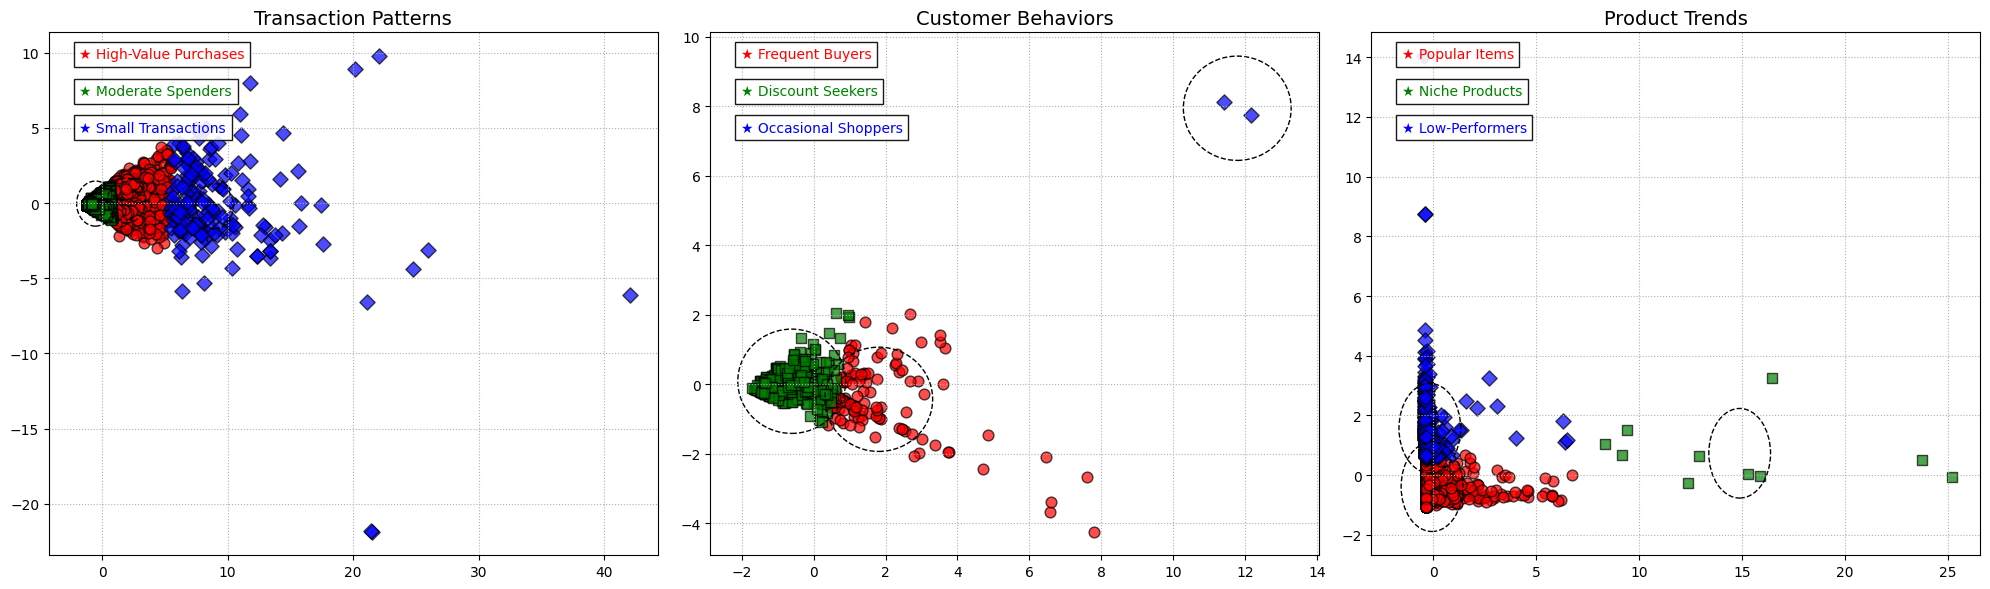

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Load and preprocess data
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(dataset_path, csv_file), parse_dates=['Date'])
df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})

# Function to create clusters with PCA transformation
def create_clusters(data, features, n_clusters=3):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data[features])
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(scaled)
    return pca_data, kmeans, pca

# 1. Transaction Value Clusters (grouped by InvoiceID)
trans_features = ['TotalSales', 'Quantity', 'Discount']
trans_df = df.groupby('InvoiceID').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum'
}).reset_index()
trans_pca, trans_kmeans, trans_pca_model = create_clusters(trans_df, trans_features)

# 2. Customer Behavior Clusters (grouped by CustomerID)
cust_features = ['TotalSales', 'Quantity', 'Discount']
cust_df = df.groupby('CustomerID').agg({
    'TotalSales': 'mean',
    'Quantity': 'mean',
    'Discount': 'mean'
}).reset_index()
cust_pca, cust_kmeans, cust_pca_model = create_clusters(cust_df, cust_features)

# 3. Product Popularity Clusters (grouped by ProductID)
prod_features = ['TotalSales', 'Quantity', 'Discount']
prod_df = df.groupby('ProductID').agg({
    'TotalSales': 'sum',
    'Quantity': 'count',
    'Discount': 'mean'
}).reset_index()
prod_pca, prod_kmeans, prod_pca_model = create_clusters(prod_df, prod_features)

# Set up plot configuration
plt.figure(figsize=(20, 6))
colors = ['red', 'green', 'blue']
titles = ['Transaction Patterns', 'Customer Behaviors', 'Product Trends']
# Each dataset tuple: (pca_data, kmeans model, PCA model)
datasets = [(trans_pca, trans_kmeans, trans_pca_model),
            (cust_pca, cust_kmeans, cust_pca_model),
            (prod_pca, prod_kmeans, prod_pca_model)]

# Descriptive stories for each cluster per perspective
stories = {
    0: ["High-Value Purchases", "Frequent Buyers", "Popular Items"],
    1: ["Moderate Spenders", "Discount Seekers", "Niche Products"],
    2: ["Small Transactions", "Occasional Shoppers", "Low-Performers"]
}

for idx, (pca_data, model, pca_model) in enumerate(datasets, 1):
    plt.subplot(1, 3, idx)

    # Plot clustered data points with matching colors and markers
    markers = ['o', 's', 'D']
    for i in range(3):
        plt.scatter(
            pca_data[model.labels_ == i, 0],
            pca_data[model.labels_ == i, 1],
            s=60,
            c=colors[i],
            edgecolor='black',
            marker=markers[i],
            alpha=0.7
        )

    # Create cluster circles using the PCA-transformed centroids
    centers = pca_model.transform(model.cluster_centers_)
    for center in centers:
        plt.gca().add_patch(
            plt.Circle(center, 1.5, fill=False, linestyle='--', color='black')
        )

    # Add descriptive labels with colors matching the clusters
    for i in range(3):
        plt.text(
            0.05,               # X position in axes coordinates
            0.95 - i * 0.07,    # Y position with a vertical shift per label
            f"★ {stories[i][idx-1]}",
            color=colors[i],    # Matching color
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.9)
        )

    plt.title(titles[idx-1], fontsize=14)
    plt.grid(ls=':')

plt.tight_layout()
plt.show()


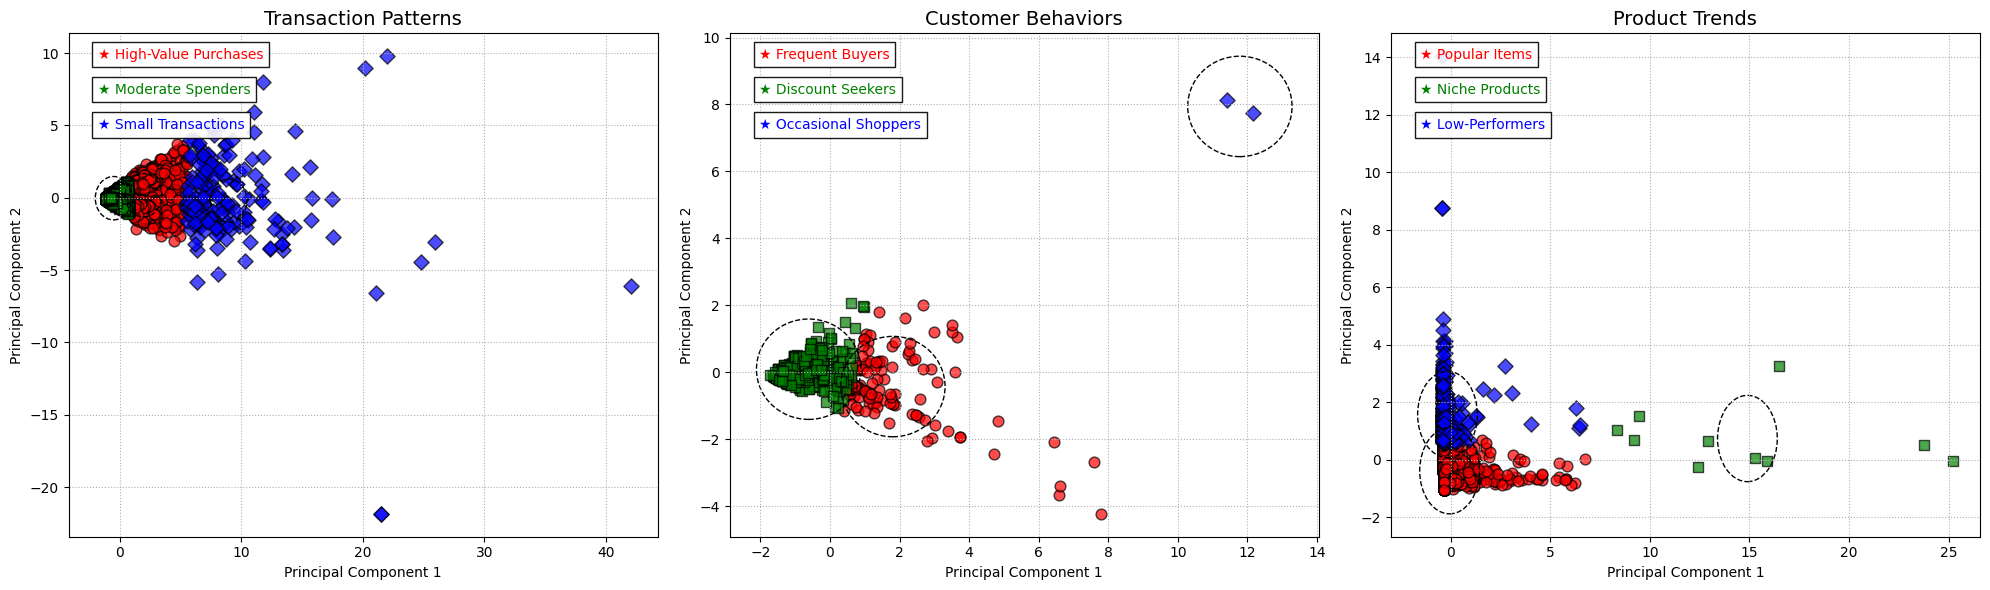

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Load and preprocess data
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(dataset_path, csv_file), parse_dates=['Date'])
df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})

# Function to create clusters with PCA transformation
def create_clusters(data, features, n_clusters=3):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data[features])
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(scaled)
    return pca_data, kmeans, pca

# 1. Transaction Value Clusters (grouped by InvoiceID)
trans_features = ['TotalSales', 'Quantity', 'Discount']
trans_df = df.groupby('InvoiceID').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum'
}).reset_index()
trans_pca, trans_kmeans, trans_pca_model = create_clusters(trans_df, trans_features)

# 2. Customer Behavior Clusters (grouped by CustomerID)
cust_features = ['TotalSales', 'Quantity', 'Discount']
cust_df = df.groupby('CustomerID').agg({
    'TotalSales': 'mean',
    'Quantity': 'mean',
    'Discount': 'mean'
}).reset_index()
cust_pca, cust_kmeans, cust_pca_model = create_clusters(cust_df, cust_features)

# 3. Product Popularity Clusters (grouped by ProductID)
prod_features = ['TotalSales', 'Quantity', 'Discount']
prod_df = df.groupby('ProductID').agg({
    'TotalSales': 'sum',
    'Quantity': 'count',
    'Discount': 'mean'
}).reset_index()
prod_pca, prod_kmeans, prod_pca_model = create_clusters(prod_df, prod_features)

# Set up plot configuration
plt.figure(figsize=(20, 6))
colors = ['red', 'green', 'blue']
titles = ['Transaction Patterns', 'Customer Behaviors', 'Product Trends']
# Each dataset tuple: (pca_data, kmeans model, PCA model)
datasets = [(trans_pca, trans_kmeans, trans_pca_model),
            (cust_pca, cust_kmeans, cust_pca_model),
            (prod_pca, prod_kmeans, prod_pca_model)]

# Descriptive stories for each cluster per perspective
stories = {
    0: ["High-Value Purchases", "Frequent Buyers", "Popular Items"],
    1: ["Moderate Spenders", "Discount Seekers", "Niche Products"],
    2: ["Small Transactions", "Occasional Shoppers", "Low-Performers"]
}

for idx, (pca_data, model, pca_model) in enumerate(datasets, 1):
    plt.subplot(1, 3, idx)

    # Plot clustered data points with matching colors and markers
    markers = ['o', 's', 'D']
    for i in range(3):
        plt.scatter(
            pca_data[model.labels_ == i, 0],
            pca_data[model.labels_ == i, 1],
            s=60,
            c=colors[i],
            edgecolor='black',
            marker=markers[i],
            alpha=0.7
        )

    # Create cluster circles using the PCA-transformed centroids
    centers = pca_model.transform(model.cluster_centers_)
    for center in centers:
        plt.gca().add_patch(
            plt.Circle(center, 1.5, fill=False, linestyle='--', color='black')
        )

    # Add descriptive labels with colors matching the clusters
    for i in range(3):
        plt.text(
            0.05,               # X position in axes coordinates
            0.95 - i * 0.07,    # Y position with a vertical shift per label
            f"★ {stories[i][idx-1]}",
            color=colors[i],    # Matching color
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.9)
        )

    # Add axis labels for clarity on PCA component scales
    plt.xlabel("Principal Component 1", fontsize=10)
    plt.ylabel("Principal Component 2", fontsize=10)

    plt.title(titles[idx-1], fontsize=14)
    plt.grid(ls=':')

plt.tight_layout()
plt.show()


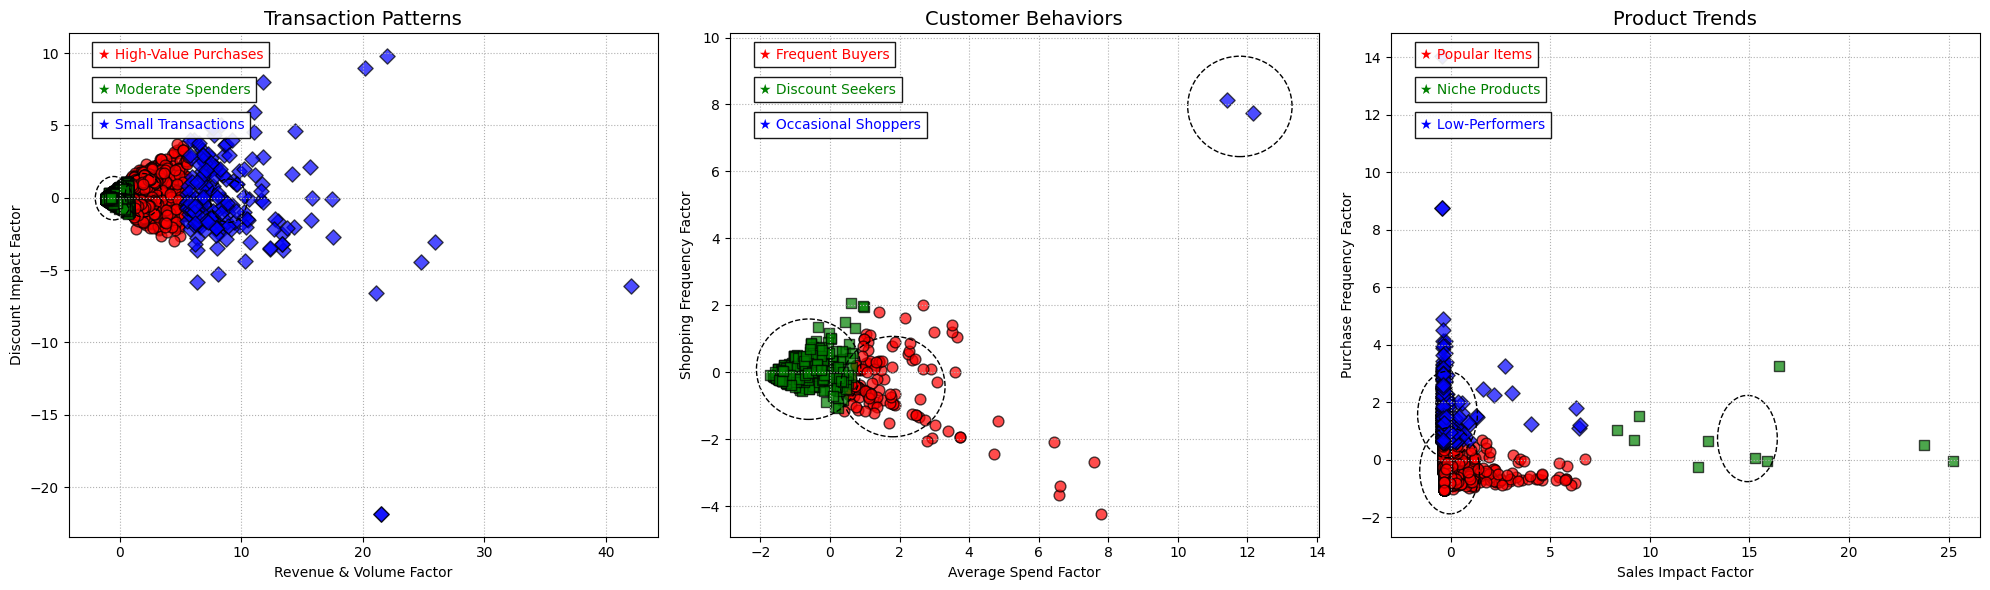

In [ ]:
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

# Load and preprocess data
dataset_path = kagglehub.dataset_download("shedai/retail-data-set")
csv_file = [f for f in os.listdir(dataset_path) if f.endswith('.csv')][0]
df = pd.read_csv(os.path.join(dataset_path, csv_file), parse_dates=['Date'])
df = df.rename(columns={'DocumentID': 'InvoiceID', 'SKU': 'ProductID', 'Price': 'TotalSales'})

# Function to create clusters (K-Means) and reduce dimensions (PCA)
def create_clusters(data, features, n_clusters=3):
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data[features])
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(scaled)
    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42).fit(scaled)
    return pca_data, kmeans, pca

# 1. Transaction Patterns
trans_features = ['TotalSales', 'Quantity', 'Discount']
trans_df = df.groupby('InvoiceID').agg({
    'TotalSales': 'sum',
    'Quantity': 'sum',
    'Discount': 'sum'
}).reset_index()
trans_pca, trans_kmeans, trans_pca_model = create_clusters(trans_df, trans_features)

# 2. Customer Behavior Clusters
cust_features = ['TotalSales', 'Quantity', 'Discount']
cust_df = df.groupby('CustomerID').agg({
    'TotalSales': 'mean',
    'Quantity': 'mean',
    'Discount': 'mean'
}).reset_index()
cust_pca, cust_kmeans, cust_pca_model = create_clusters(cust_df, cust_features)

# 3. Product Popularity Clusters
prod_features = ['TotalSales', 'Quantity', 'Discount']
prod_df = df.groupby('ProductID').agg({
    'TotalSales': 'sum',
    'Quantity': 'count',
    'Discount': 'mean'
}).reset_index()
prod_pca, prod_kmeans, prod_pca_model = create_clusters(prod_df, prod_features)

# Plot Configuration
plt.figure(figsize=(20, 6))
colors = ['red', 'green', 'blue']
titles = ['Transaction Patterns', 'Customer Behaviors', 'Product Trends']
datasets = [
    (trans_pca, trans_kmeans, trans_pca_model),
    (cust_pca, cust_kmeans, cust_pca_model),
    (prod_pca, prod_kmeans, prod_pca_model)
]

# Define axis labels per perspective for added clarity
axis_labels = {
    "Transaction Patterns": ("Revenue & Volume Factor", "Discount Impact Factor"),
    "Customer Behaviors": ("Average Spend Factor", "Shopping Frequency Factor"),
    "Product Trends": ("Sales Impact Factor", "Purchase Frequency Factor")
}

stories = {
    0: ["High-Value Purchases", "Frequent Buyers", "Popular Items"],
    1: ["Moderate Spenders", "Discount Seekers", "Niche Products"],
    2: ["Small Transactions", "Occasional Shoppers", "Low-Performers"]
}

markers = ['o', 's', 'D']

for idx, (pca_data, model, pca_model) in enumerate(datasets, 1):
    plt.subplot(1, 3, idx)

    # Scatter plot for each cluster
    for i in range(3):
        plt.scatter(
            pca_data[model.labels_ == i, 0],
            pca_data[model.labels_ == i, 1],
            s=60,
            c=colors[i],
            edgecolor='black',
            marker=markers[i],
            alpha=0.7
        )

    # Circles around centroids (transformed via PCA)
    centers = pca_model.transform(model.cluster_centers_)
    for center in centers:
        plt.gca().add_patch(
            plt.Circle(center, 1.5, fill=False, linestyle='--', color='black')
        )

    # Descriptive labels in the same color as cluster points
    for i in range(3):
        plt.text(
            0.05,
            0.95 - i * 0.07,
            f"★ {stories[i][idx-1]}",
            color=colors[i],
            transform=plt.gca().transAxes,
            bbox=dict(facecolor='white', alpha=0.9)
        )

    # Set domain-specific axis labels for each perspective
    title = titles[idx-1]
    plt.xlabel(axis_labels[title][0], fontsize=10)
    plt.ylabel(axis_labels[title][1], fontsize=10)

    plt.title(title, fontsize=14)
    plt.grid(ls=':')

plt.tight_layout()
plt.show()
